<a href="https://colab.research.google.com/github/Rosental14/Study/blob/main/Labs/Lab_10%20-%20E2E%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - End-to-end Machine Learning

## Dataset

Vamos trabalhar com dataset de e-commerce da [Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

Neste dataset temos informações de ordens, entrega, localizações, reviews, preços e etc

## Hipótese

**Será que podemos prever qual rating que o cliente dará ao serviço?**

Quais os motivos para que um pedido seja mal avaliado?


1.   Atraso na entrega
2.   Pedido veio errado, com defeito ou não satisfez a necessidade do cliente

## O Fluxo de Modelagem:

Este fluxo deve ser cíclico, ou seja, devemos repetir os passos até chegar na performance adequada do modelo.

1. Construção do Dataset
  * Join / Merge com as tabelas e construção de uma base analítica
  * Limpeza e pré-processamento da base
2. EDA
  * Uma análise minuciosa dos dados que será insumo para feature engineering e modelagem
3. Feature Engineering
  * Construção de novas variáveis informativas que podem ajudar o modelo a encontrar melhor os padrões nos dados
  * Podemos realizar também um feature selection, ou seja, remover variáveis não informativas que degradam a performance do modelo
4. Modelagem
  * Train / Test split dos dados para evitar overfitting
  * Construção de um baseline a ser batido
  * Construção de modelos propícios ao problema a ser resolvido
5. Tuning de Hiperparâmetros
  * Utilizar o conjunto de validação para tuning dos hiperparâmetros dos modelos candidatos
6. Model Selection
  * Nesta etapa já deveríamos ter uma métrica de performance principal que queremos otimizar. Essa métrica deve ter relação com o negócio, ou seja, melhorias na métrica do modelo implica em melhoria nas métricas de negócio
  * Escolha do melhor modelo (aquele com melhor performance no conjunto de teste)
7. Análise de Performance
  * Dado um melhor modelo escolhido (ou uma short-list de melhores modelos). É importante tentar entender como estes modelos performam no conjunto de dados.
  * Vamos aplicar ferramentas de interpretabilidade para entender as principais features utilizadas
  * vamos analisar os erros no conjunto de teste para verificar possíveis viéses. Estas análises podem ser insumo para recomeçar este processo e construir novas features e/ou novos modelos



## Dicas para Modelagem

#### Before Machine Learning
- Do not default to Machine Learning
- Quantify the problem before considering ML
- Implement metrics tracking before ML system design
- Favor simple heuristics over ML, but ML over cumbersome heuristics

#### Your first model

- Design for rapid iteration
- Start with a simple observable objective
- Validate data thoroughly before training
- Encode heuristics into features when possible
- Connect ML objectives to your company strategic goals
- Favor simple, interpretable features over marginal ML gains
- Start with interpretable models that make debugging easier
- Remember that model selection scales with data availability
- Pick a simple, observable and attributable metric for your objective
- Ensure adequate sample sizes for reliable model training and inference

#### Your first pipeline

- Maintain data pipeline integrity
- Sanity check performance before deployment
- Test infrastructure separately from machine learning
- Focus on getting the surrounding model infrastructure in place
- Understand model freshness requirements and performance decay
- Monitor for silent failures like concept drift, data errors & dependency

#### Feature Engineering

- Document features thoroughly
- Remove unused features promptly
- Prefer observed features over learned ones
- Favor features that generalize across contexts
- Scale feature engineering complexity based on available data
- For large datasets, prefer simple, sparse features over complex ones
- Favor human-interpretable operations like binning and combinations

#### Internal Testing

- Derive new features from observed errors
- Quantify issues before attempting solutions
- Supplement internal feedback with external validation
- Prioritize downstream performance over prediction metrics
- Benchmark new models against existing production baselines
- Assess model long-term learning potential, not just short-term metrics

#### Production Drift

- Reuse code for consistency
- Log production features for consistency
- Keep ensembles simple, avoid stacking models
- Prioritize importance weighting over arbitrary data drops
- Stay aligned with #5 and #6 to avoid unnecessary feature engineering
- Prefer new quality data rather than over-engineering existing features
- Understand launch depend on many factors, not just ML optimization

#### The basic approach is:

↳ start with a reasonably simple objective and metrics  
↳ add common-sense features without adding complexity <br>
↳ make sure your pipeline stay completely solid end to end




Neste notebook, vamos simplificar todas estas etapas, como por exemplo a EDA. Porém, cabe a cada um aprimorar este pipeline para encontrar melhores modelos, como por exemplo: testar diferentes tipos de feature engineering, encoding e modelos.

In [ ]:
# acesso google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings

from pathlib import Path
import pickle
warnings.filterwarnings('ignore')

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Construção do Dataset

### Leitura

Vamos ler todos os CSVs do dataset e fazer os merges necessários

In [ ]:
df_o = pd.read_csv('olist_orders_dataset.csv', parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',	'order_delivered_customer_date',	'order_estimated_delivery_date'])
df_oi = pd.read_csv('olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date'])
df_op = pd.read_csv('olist_order_payments_dataset.csv')
df_or = pd.read_csv('olist_order_reviews_dataset.csv')
df_p = pd.read_csv('olist_products_dataset.csv')
df_s = pd.read_csv('olist_sellers_dataset.csv')
df_c = pd.read_csv('olist_customers_dataset.csv')
df_l = pd.read_csv('olist_geolocation_dataset.csv')
df_pc = pd.read_csv('product_category_name_translation.csv')

In [ ]:
df_l_grouped = df_l.groupby('geolocation_zip_code_prefix')[['geolocation_lat',	'geolocation_lng'	]].mean().reset_index()

### Merges

In [ ]:
df_o = pd.merge(left = df_o, right = df_c, on = ['customer_id'], how = 'left')
df_o = pd.merge(left = df_o, right = df_op.groupby('order_id')['payment_value'].sum(), on = ['order_id'], how = 'left')
df_o = pd.merge(left = df_o, right = df_or.groupby('order_id')['review_score'].mean().reset_index(),
                on = ['order_id'],
                how = 'left')
df_o = pd.merge(left = df_o,
                right = df_l_grouped.rename(columns = {'geolocation_lat' : 'c_lat',	'geolocation_lng' : 'c_lng'}),
                left_on = 'customer_zip_code_prefix',
                right_on = 'geolocation_zip_code_prefix',
                how = 'left')

df_oi = pd.merge(left = df_oi, right = df_p, on = ['product_id'], how = 'left')
df_oi = pd.merge(left = df_oi, right = df_s, on = ['seller_id'], how = 'left')
df_oi = pd.merge(left = df_oi,
                 right = df_l_grouped.rename(columns = {'geolocation_lat' : 's_lat',	'geolocation_lng' : 's_lng'}),
                 left_on = 'seller_zip_code_prefix',
                 right_on = 'geolocation_zip_code_prefix',
                 how = 'left')

In [ ]:
df_o.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   payment_value  review_score  geolocation_zip_code_prefix      c_lat  \
0          38.71           4.0                       3149.0 -23.576983   
1         141.46           4.0                      47813.0 -12.177924   
2         179.12           5.0                      75265.0 -16.745150   
3          72.20           5.0                      59296.0  -5.774190   
4          28.62           5.0                       9195.0 -23.676370   

       c_lng  
0 -46.587161  
1 -44.660711  
2 -48.514783  
3 -35.271143  
4 -46.514627

In [ ]:
df_oi.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value product_category_name  \
0 2017-09-19 09:45:35   58.90          13.29            cool_stuff   
1 2017-05-03 11:05:13  239.90          19.93              pet_shop   
2 2018-01-18 14:48:30  199.00          17.87      moveis_decoracao   
3 2018-08-15 10:10:18   12.99          12.79            perfumaria   
4 2017-02-13 13:57:51  199.90          18.14    ferramentas_jardim   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 58.0                       598.0                 4.0   
1                 56.0                       239.0                 2.0   
2                 59.0                       695.0                 2.0   
3                 42.0                       480.0                 1.0   
4                 59.0                       409.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             650.0               28.0                9.0              14.0   
1           30000.0               50.0               30.0              40.0   
2            3050.0               33.0               13.0              33.0   
3             200.0               16.0               10.0              15.0   
4            3750.0               35.0               40.0              30.0   

   seller_zip_code_prefix    seller_city seller_state  \
0                   27277  volta redonda           SP   
1                    3471      sao paulo           SP   
2                   37564  borda da mata           MG   
3                   14403         franca           SP   
4                   87900         loanda           PR   

   geolocation_zip_code_prefix      s_lat      s_lng  
0                      27277.0 -22.496953 -44.127492  
1                       3471.0 -23.565096 -46.518565  
2                      37564.0 -22.262584 -46.171124  
3                      14403.0 -20.553624 -47.387359  
4                      87900.0 -22.929384 -53.135873

### Feature Engineering Inicial

Construindo algumas features que fazem sentido com o problema

**Distância entre sellers e customers**

In [ ]:
df_oi = pd.merge(left = df_oi, right = df_o, on = ['order_id'], how = 'left')

In [ ]:
import geopy.distance

def calculate_distance(data):
  try:
    return geopy.distance.geodesic((data['c_lat'], data['c_lng']), (data['s_lat'], data['s_lng'])).km
  except:
    return 0

df_oi['customer_seller_distance'] = df_oi.apply(calculate_distance, axis = 1)

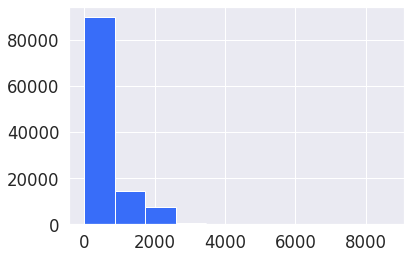

In [ ]:
df_oi['customer_seller_distance'].hist();

In [ ]:
(df_oi['customer_seller_distance'] == 0).sum()

580

In [ ]:
df_oi['product_volume'] = df_oi[['product_length_cm',	'product_height_cm','product_width_cm']].prod(axis =1)

In [ ]:
df_oi['product_category_name'].fillna('unknown', inplace = True)

**Features sobre sellers**

In [ ]:
df_oi_s = df_oi.groupby('seller_id').agg({'price' : 'sum', 'order_item_id' : 'count'}).reset_index().rename(columns = {'price' : 's_total_volume', 'order_item_id' : 's_total_items'})

In [ ]:
df_oi_s.head()

seller_id  s_total_volume  s_total_items
0  0015a82c2db000af6aaaf3ae2ecb0532         2685.00              3
1  001cca7ae9ae17fb1caed9dfb1094831        25080.03            239
2  001e6ad469a905060d959994f1b41e4f          250.00              1
3  002100f778ceb8431b7a1020ff7ab48f         1234.50             55
4  003554e2dce176b5555353e4f3555ac8          120.00              1

In [ ]:
df_oi = pd.merge(left = df_oi, right = df_oi_s, on = 'seller_id', how = 'left')

**Features sobre entregas**

In [ ]:
df_o['logistics_length'] = (df_o['order_delivered_customer_date'] - df_o['order_approved_at']).dt.days
df_o['delay_length'] = (df_o['order_delivered_customer_date'] - df_o['order_estimated_delivery_date']).dt.days
df_o['is_delayed'] = df_o['delay_length'] > 0

**Merge com base final**

In [ ]:
df_oi_g = df_oi.groupby('order_id').agg({'customer_seller_distance' : 'max',
                               'product_volume' : 'sum',
                               'product_weight_g' : 'sum',
                               'product_photos_qty' : 'sum',
                               'freight_value' : 'sum',
                               'order_item_id' : 'count',
                               'shipping_limit_date' : 'min',
                               'product_category_name' : lambda x: x.mode()[0],
                               'seller_state' : lambda x: x.mode()[0],
                               's_total_volume' : 'mean',
                               's_total_items' : 'mean',
                              }).reset_index()

In [ ]:
df_o = pd.merge(left = df_o, right = df_oi_g, on = ['order_id'], how = 'left')


In [ ]:
df_o['freight_ratio'] = df_o['freight_value'] / df_o['payment_value']

### Limpeza

Inicialmente vemos que não temos muitos dados faltantes no dataset e, dessa forma, resolvi preenchê-los. Uma decisão que pode ser revista

In [ ]:
drop_cols = ['order_id',
             'customer_id',
             'order_status',
             'order_purchase_timestamp',
             'order_approved_at',
             'order_delivered_carrier_date',
             'customer_unique_id',
             'customer_zip_code_prefix',
             'customer_city',
             'geolocation_zip_code_prefix',
             'c_lat',
             'c_lng',
             'shipping_limit_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date']
df_o.drop(columns = drop_cols, inplace = True)

In [ ]:
df_o.isna().mean() * 100

customer_state              0.000000
payment_value               0.001006
review_score                0.772317
logistics_length            2.995746
delay_length                2.981668
is_delayed                  0.000000
customer_seller_distance    0.779357
product_volume              0.779357
product_weight_g            0.779357
product_photos_qty          0.779357
freight_value               0.779357
order_item_id               0.779357
product_category_name       0.779357
seller_state                0.779357
s_total_volume              0.779357
s_total_items               0.779357
freight_ratio               0.780362
dtype: float64

### Definiçao do Target

Vamos definir como target prever se um pedido teve 5 estrelas, ou seja, transformando o problema em classificação binária

In [ ]:
df_o['review_score'].value_counts()

5.000000    56955
4.000000    19018
1.000000    11316
3.000000     8136
2.000000     3125
4.500000       54
2.500000       34
3.500000       25
1.500000        8
3.333333        1
4.333333        1
Name: review_score, dtype: int64

In [ ]:
df_o['target'] = np.where(df_o['review_score'] < 5, '0', '1')

In [ ]:
df_o['target'].value_counts()

1    57723
0    41718
Name: target, dtype: int64

In [ ]:
df_o.drop(columns = ['review_score'], inplace = True)

### Agrupamento de Estados

Aqui faremos agrupamentos de categorias (faltou fazer na feature de categoria de produto). De forma simplificada, vamos agrupar categorias que tem poucas amostras.

Poderíamos aprimorar e fazer um agrupamento com base no likelihood ratio test. (*to do*)

In [ ]:
df_o['customer_state'].nunique()

27

In [ ]:
df_o['seller_state'].nunique()

23

In [ ]:
df_o['customer_state'].value_counts()

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

In [ ]:
df_o['customer_state'] = df_o['customer_state'].map({'SP': 'SP',
                      'BA': 'BA',
                      'GO': 'GO',
                      'RN': 'NE',
                      'PR': 'PR',
                      'RS': 'RS',
                      'RJ': 'RJ',
                      'MG': 'MG',
                      'SC': 'SC',
                      'RR': 'N',
                      'PE': 'PE',
                      'TO': 'N',
                      'CE': 'CE',
                      'DF': 'DF',
                      'SE': 'NE',
                      'MT': 'CO',
                      'PB': 'NE',
                      'PA': 'N',
                      'RO': 'N',
                      'ES': 'ES',
                      'AP': 'N',
                      'MS': 'CO',
                      'MA': 'NE',
                      'PI': 'NE',
                      'AL': 'NE',
                      'AC': 'N',
                      'AM': 'N'})

df_o['seller_state'] = df_o['seller_state'].map({'SP': 'SP',
                      'BA': 'BA',
                      'GO': 'GO',
                      'RN': 'NE',
                      'PR': 'PR',
                      'RS': 'RS',
                      'RJ': 'RJ',
                      'MG': 'MG',
                      'SC': 'SC',
                      'RR': 'N',
                      'PE': 'PE',
                      'TO': 'N',
                      'CE': 'CE',
                      'DF': 'DF',
                      'SE': 'NE',
                      'MT': 'CO',
                      'PB': 'NE',
                      'PA': 'N',
                      'RO': 'N',
                      'ES': 'ES',
                      'AP': 'N',
                      'MS': 'CO',
                      'MA': 'NE',
                      'PI': 'NE',
                      'AL': 'NE',
                      'AC': 'N',
                      'AM': 'N'})

In [ ]:
df_o.to_csv('olist_final_dataset.csv', index = False)

## Feature Selection Inicial

Vamos avaliar as features inicias com base em correlação, quantidade de missing, feature importance de um LGBM


In [ ]:
df = pd.read_csv('olist_final_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16678 entries, 0 to 16677
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_state            16678 non-null  object 
 1   payment_value             16678 non-null  float64
 2   logistics_length          16206 non-null  float64
 3   delay_length              16207 non-null  float64
 4   is_delayed                16677 non-null  object 
 5   customer_seller_distance  16549 non-null  float64
 6   product_volume            16549 non-null  float64
 7   product_weight_g          16549 non-null  float64
 8   product_photos_qty        16549 non-null  float64
 9   freight_value             16549 non-null  float64
 10  order_item_id             16549 non-null  float64
 11  product_category_name     16549 non-null  object 
 12  seller_state              16549 non-null  object 
 13  s_total_volume            16549 non-null  float64
 14  s_tota

In [ ]:
df.head()

customer_state  payment_value  logistics_length  delay_length is_delayed  \
0             SP          38.71               8.0          -8.0      False   
1             BA         141.46              12.0          -6.0      False   
2             GO         179.12               9.0         -18.0      False   
3             NE          72.20              13.0         -13.0      False   
4             SP          28.62               2.0         -10.0      False   

   customer_seller_distance  product_volume  product_weight_g  \
0                 18.566632          1976.0             500.0   
1                847.437333          4693.0             400.0   
2                512.100044          9576.0             420.0   
3               1816.085655          6000.0             450.0   
4                 29.684401         11475.0             250.0   

   product_photos_qty  freight_value  order_item_id  product_category_name  \
0                 4.0           8.72            1.0  utilidades_domesticas   
1                 1.0          22.76            1.0             perfumaria   
2                 1.0          19.22            1.0             automotivo   
3                 3.0          27.20            1.0               pet_shop   
4                 4.0           8.72            1.0              papelaria   

  seller_state  s_total_volume  s_total_items  freight_ratio  target  
0           SP         2349.94           53.0       0.225265     0.0  
1           SP        13544.95          126.0       0.160894     0.0  
2           SP       229472.63         1156.0       0.107302     1.0  
3           MG        14362.30          156.0       0.376731     1.0  
4           SP         6109.44          174.0       0.304682     1.0

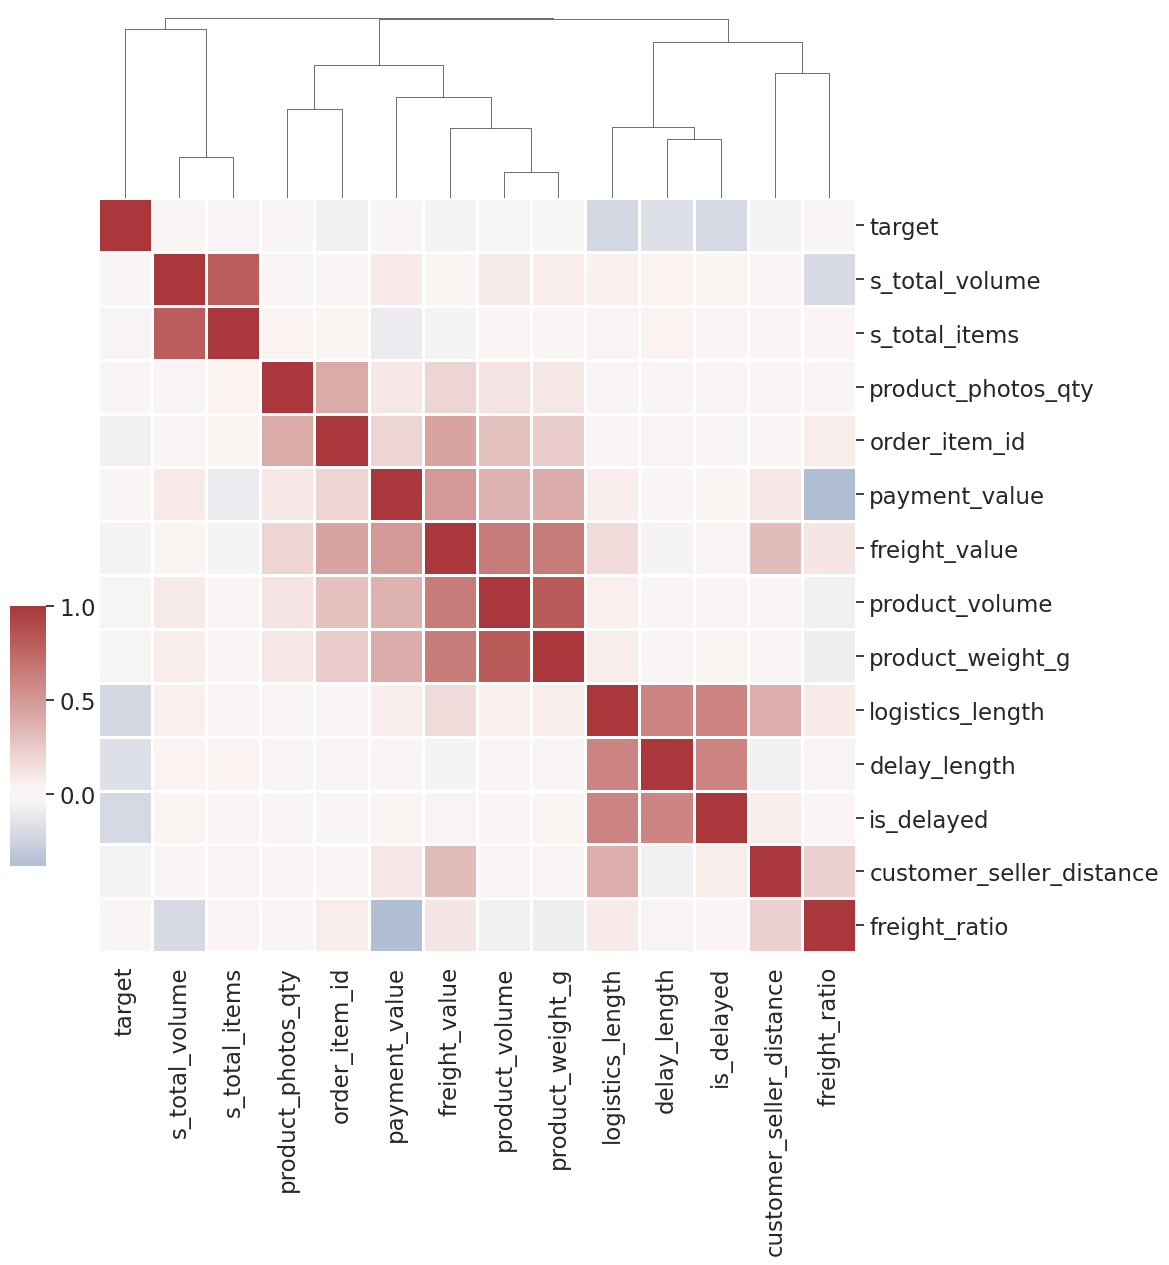

In [ ]:
g = sns.clustermap(df.corr(), center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13))
g.ax_row_dendrogram.remove()

In [ ]:
df.corr()['target'].sort_values()

logistics_length           -0.226270
is_delayed                 -0.212624
delay_length               -0.169678
order_item_id              -0.067922
freight_value              -0.058149
customer_seller_distance   -0.056573
product_weight_g           -0.039921
product_volume             -0.039881
s_total_items              -0.031767
freight_ratio              -0.027860
product_photos_qty         -0.025664
payment_value              -0.021629
s_total_volume             -0.021381
target                      1.000000
Name: target, dtype: float64

In [ ]:
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 4.3 MB/s 


In [ ]:
import sweetviz as sv
df_train, df_test = train_test_split(df, test_size = 0.3)
comparison_report = sv.compare([df_train,'Train'], [df_test,'Test'], target_feat='target')

                                             |          | [  0%]   00:00 -> (? left)


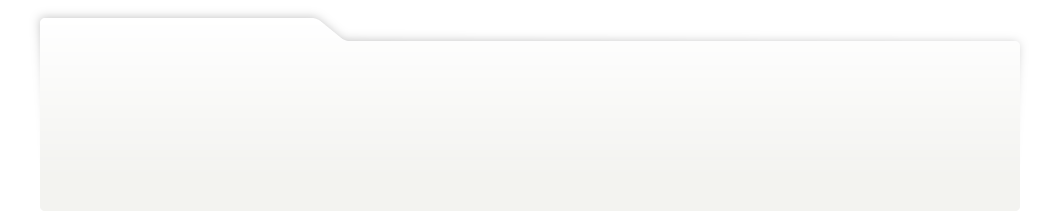
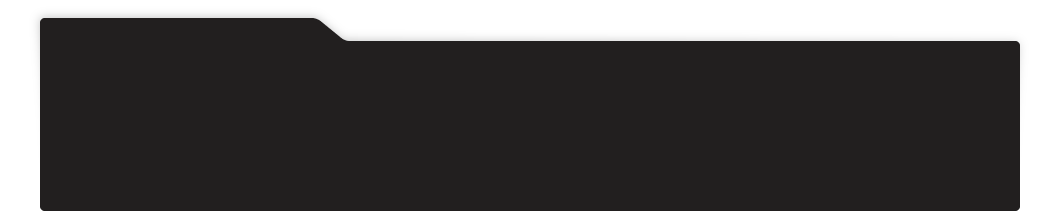
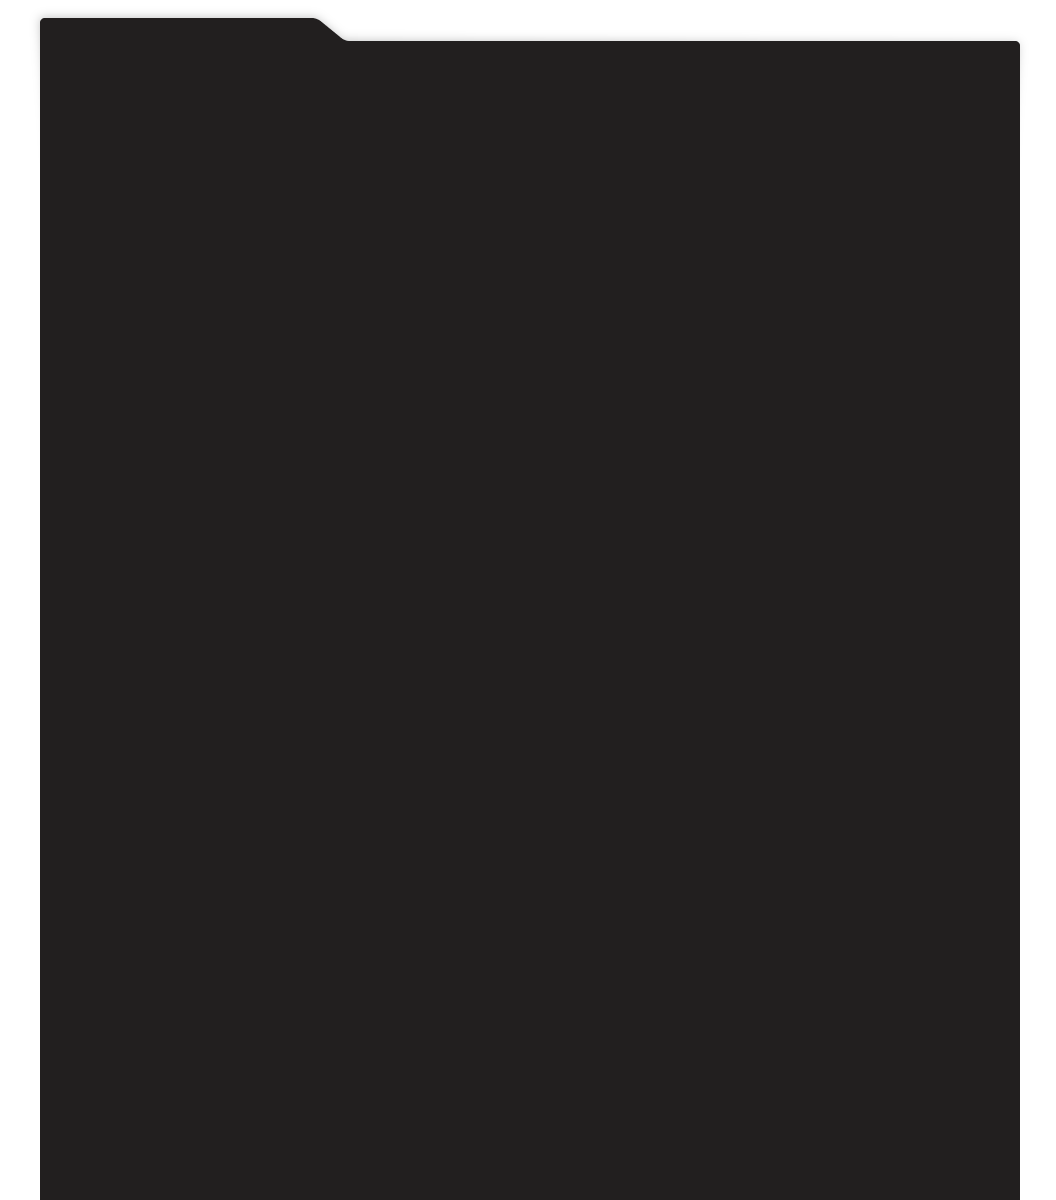
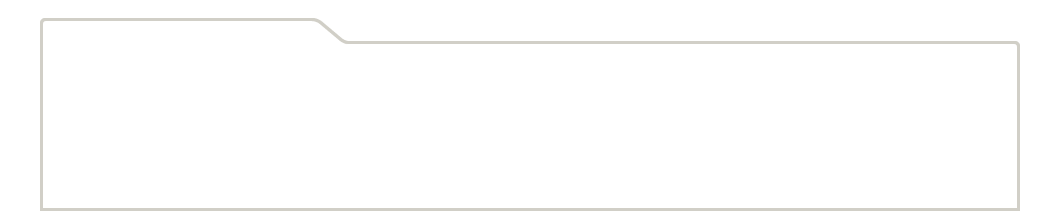
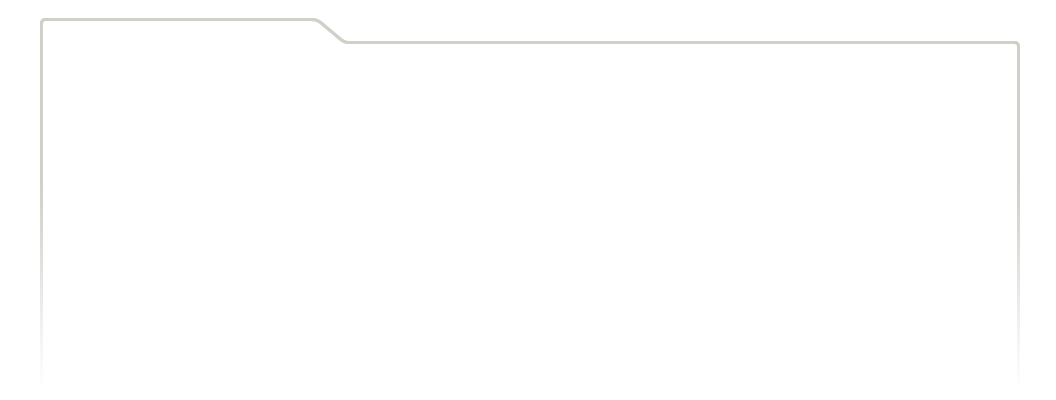
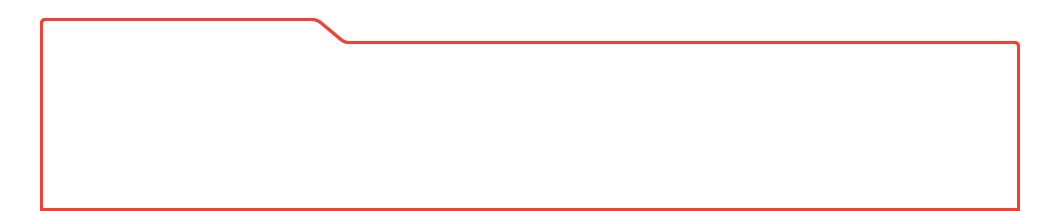
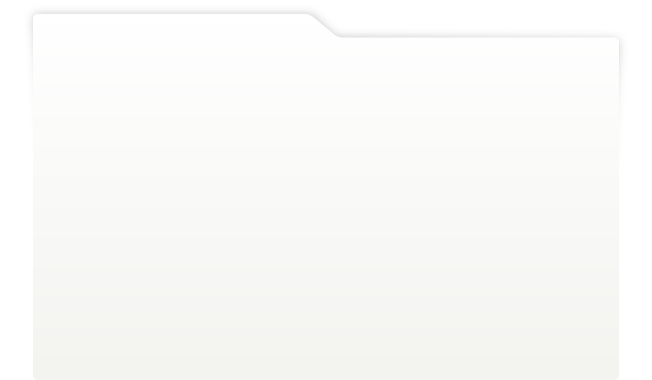
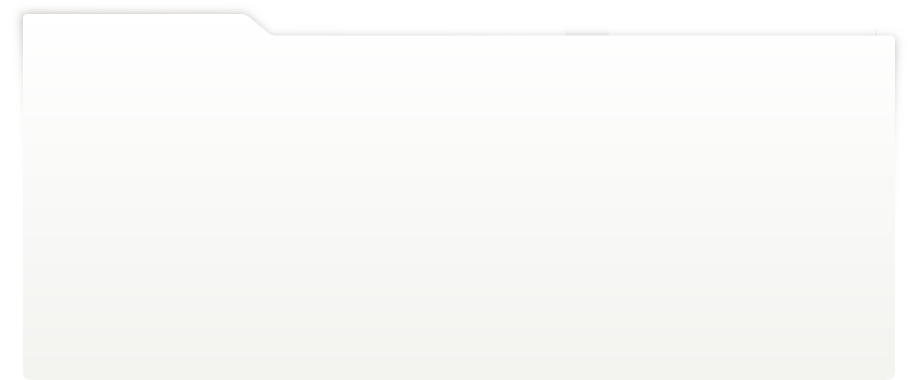
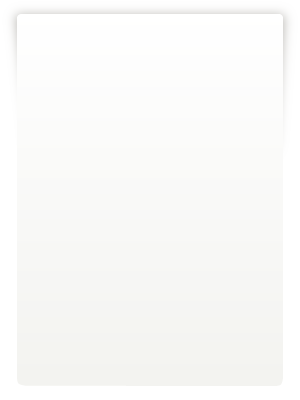
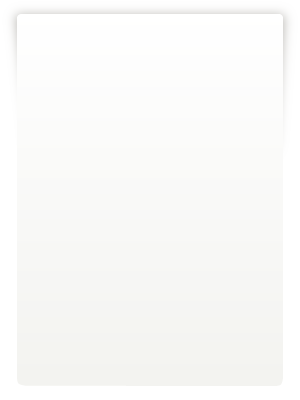
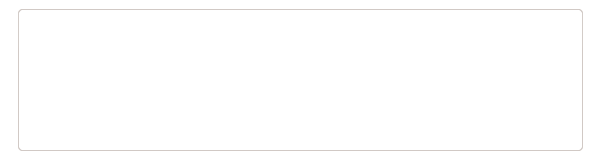
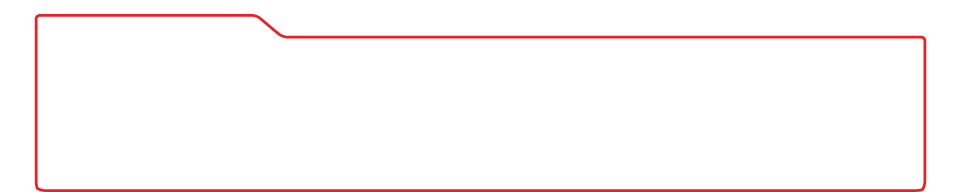
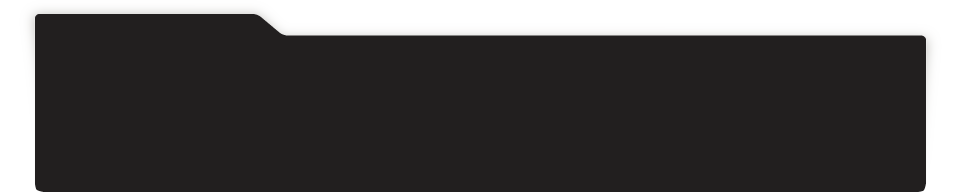
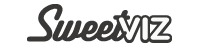
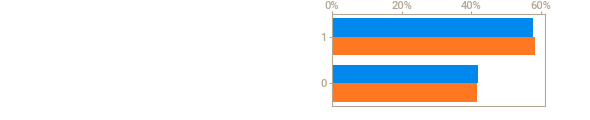
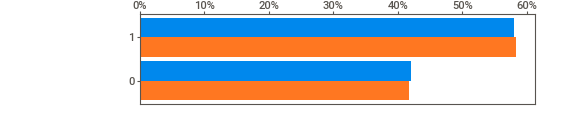
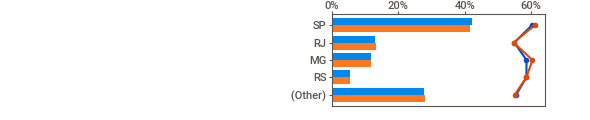
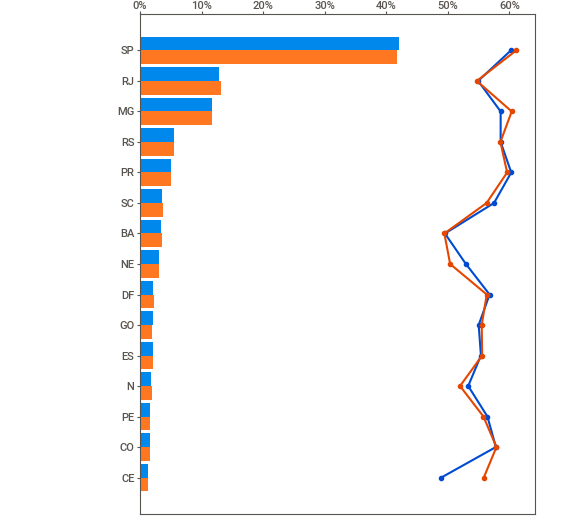
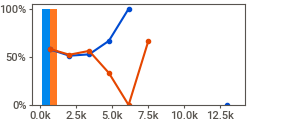
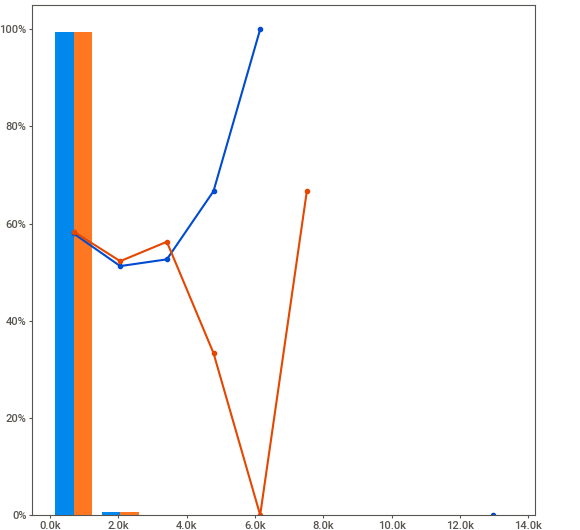
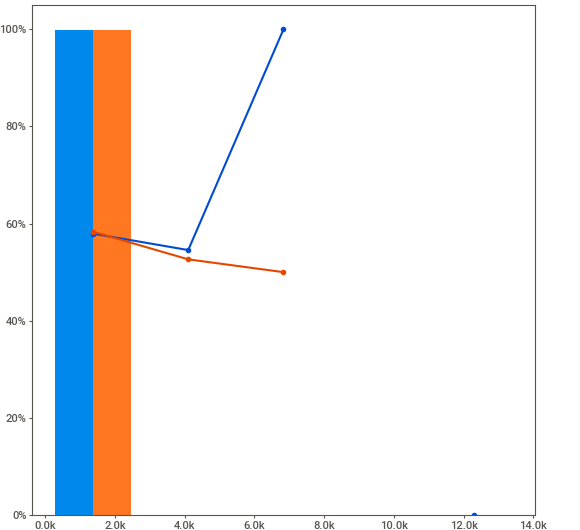
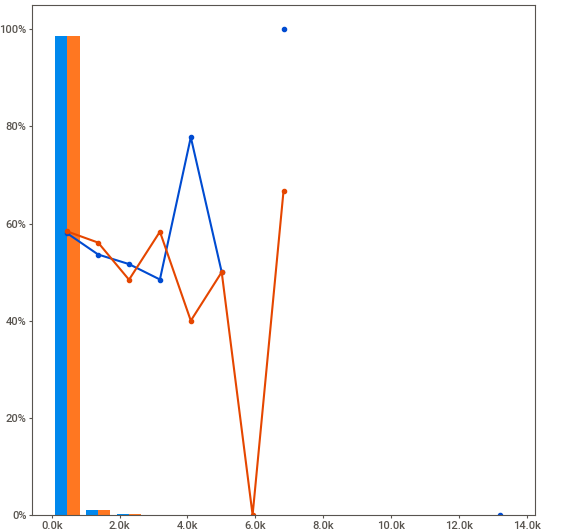
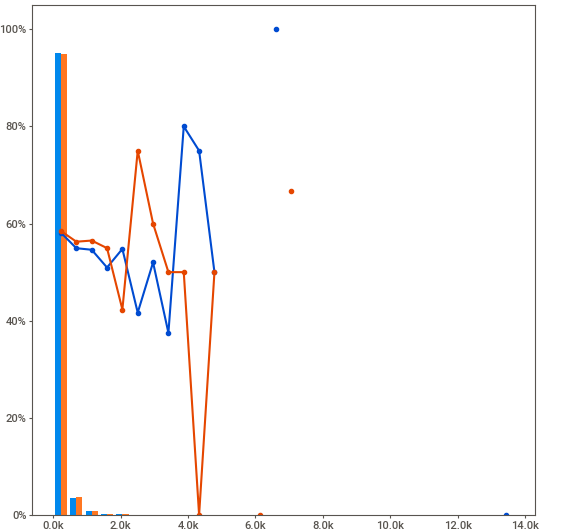
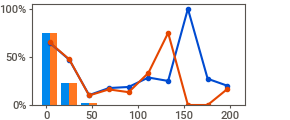
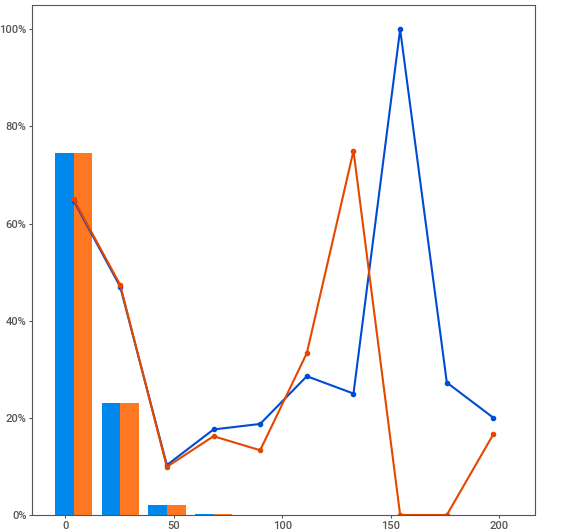
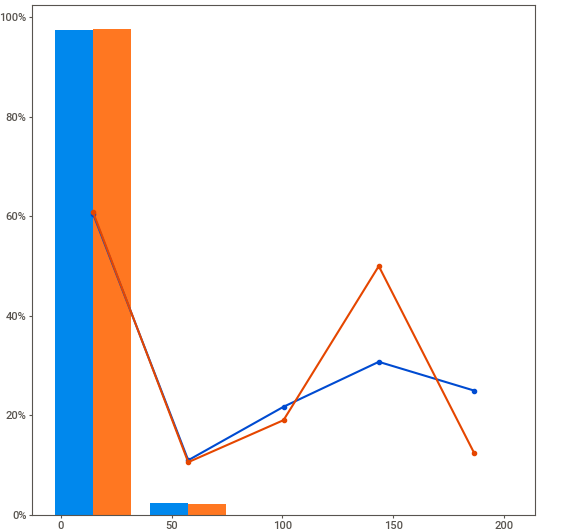
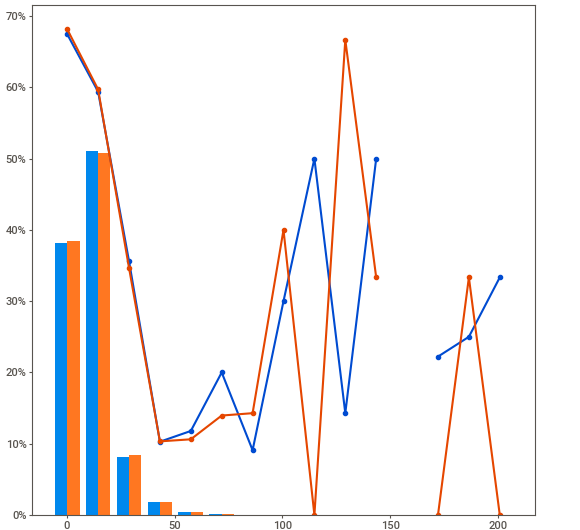
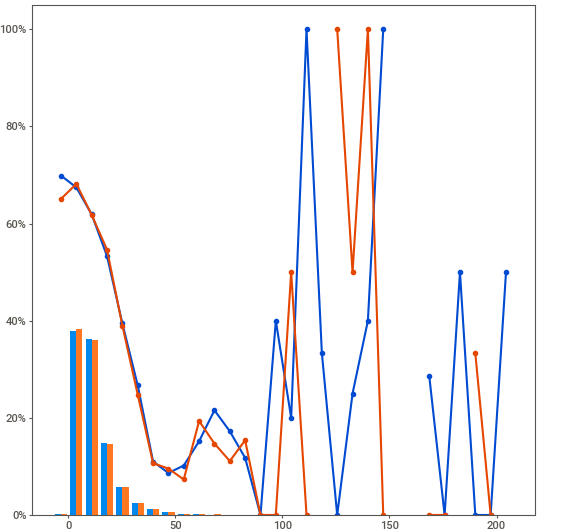
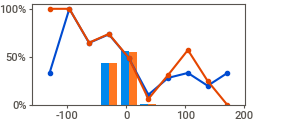
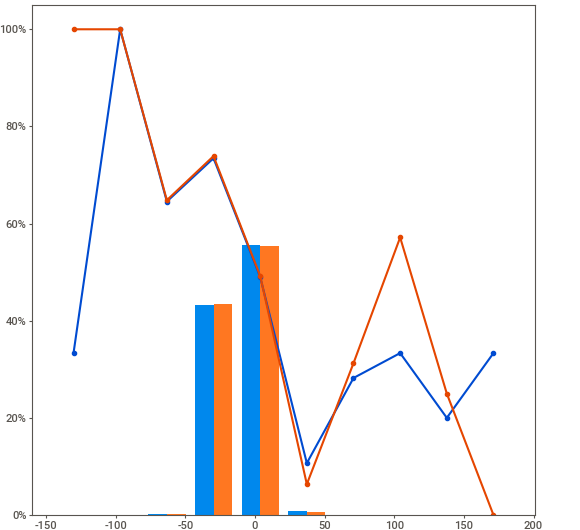
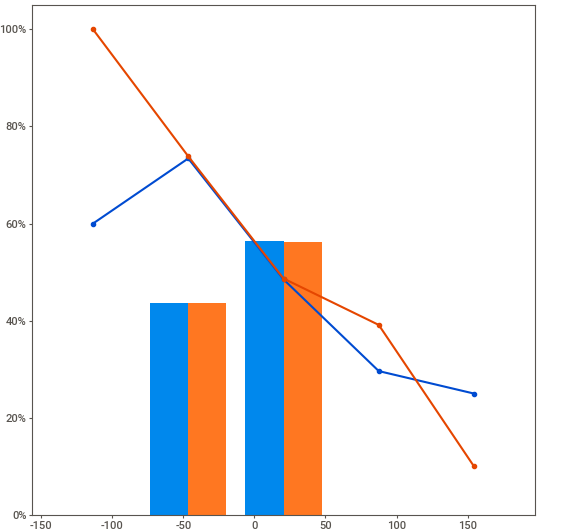
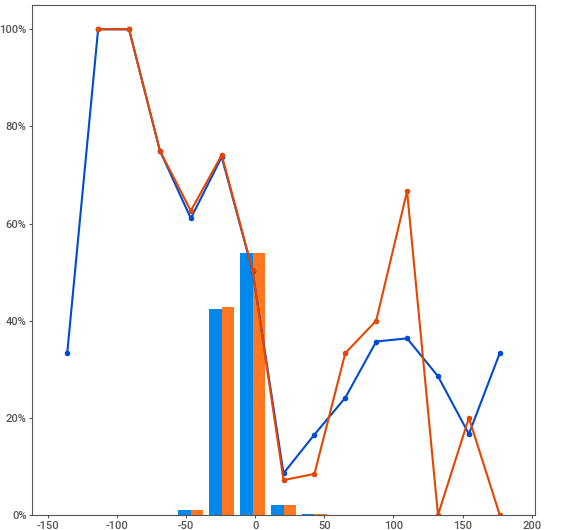
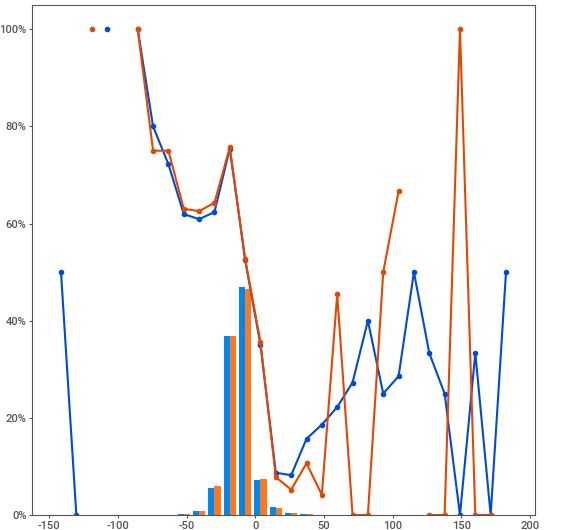
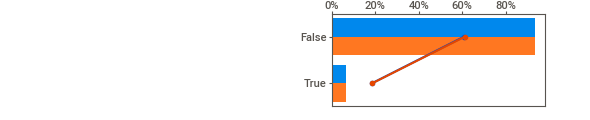
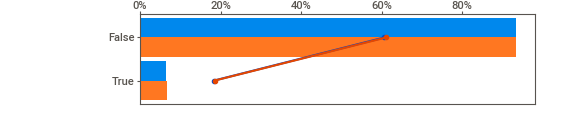
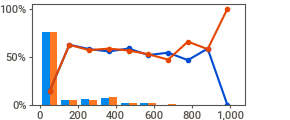
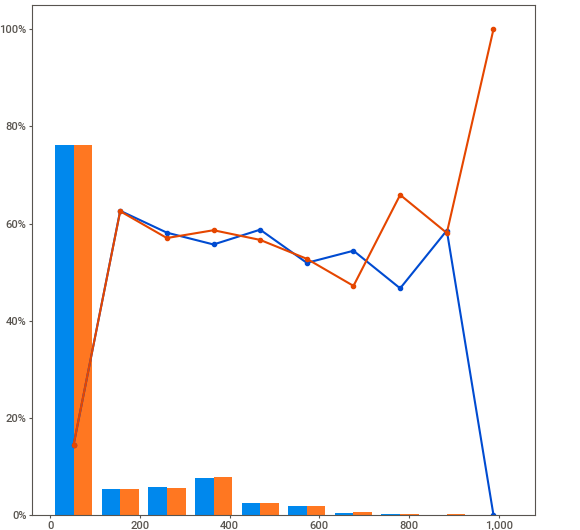
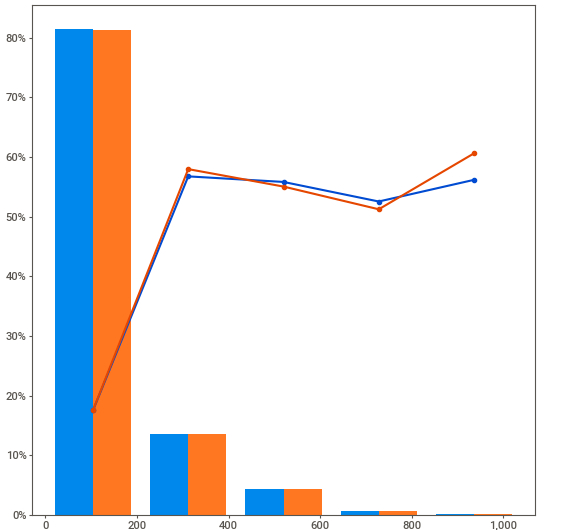
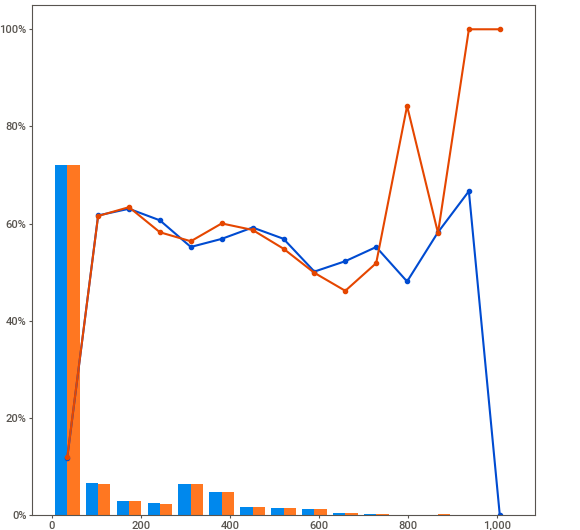
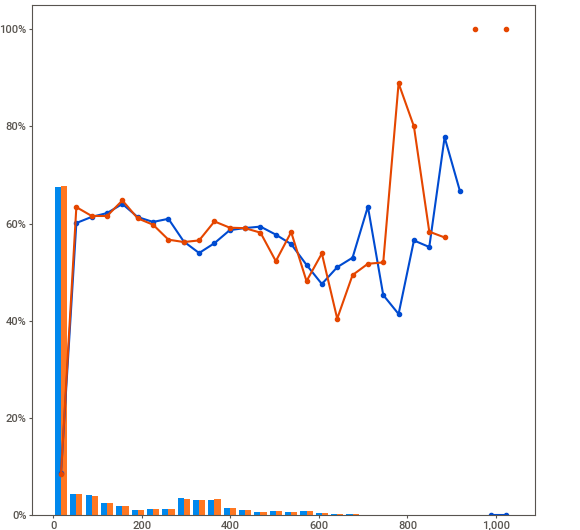
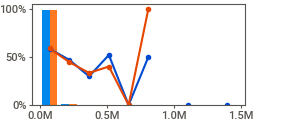
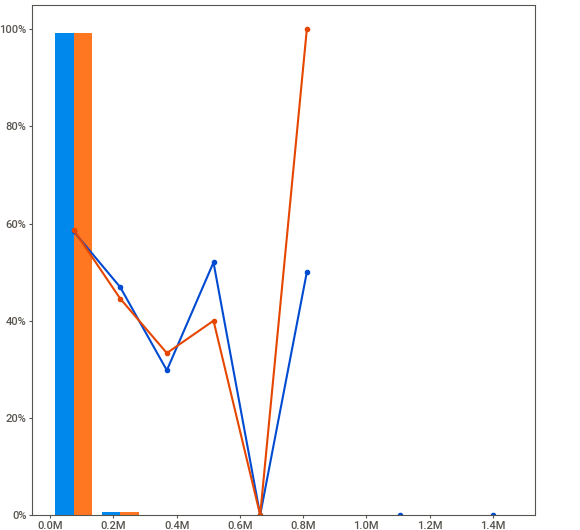
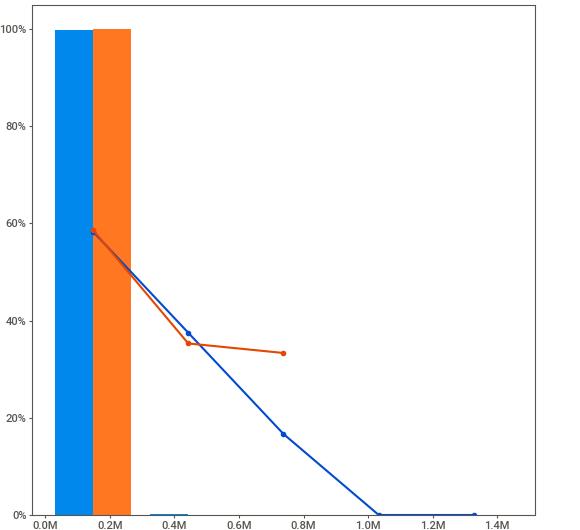
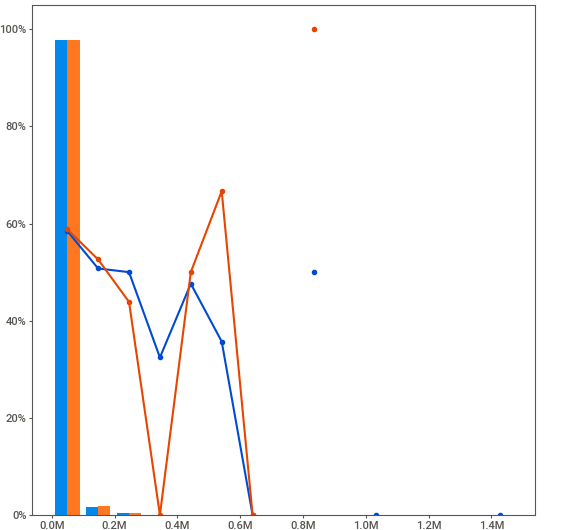
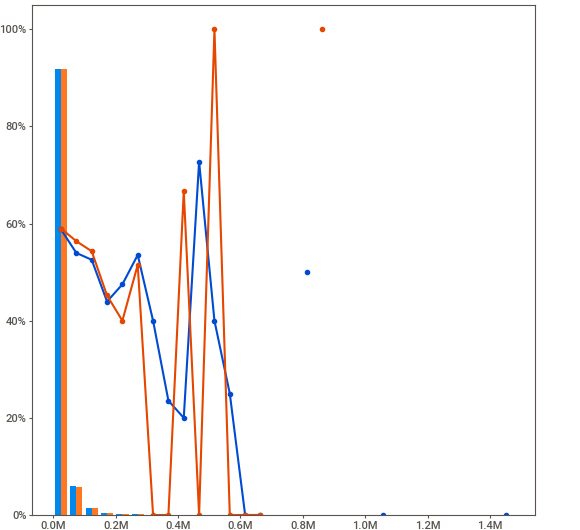
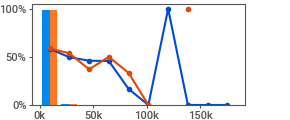
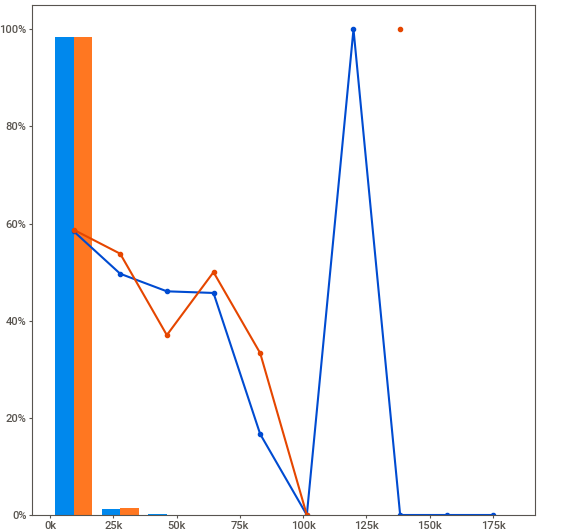
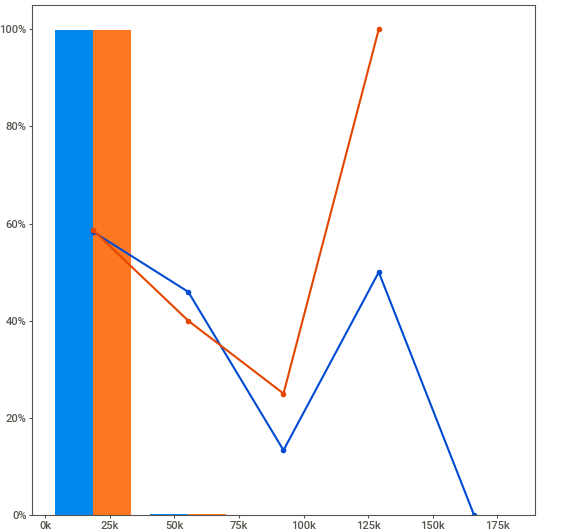
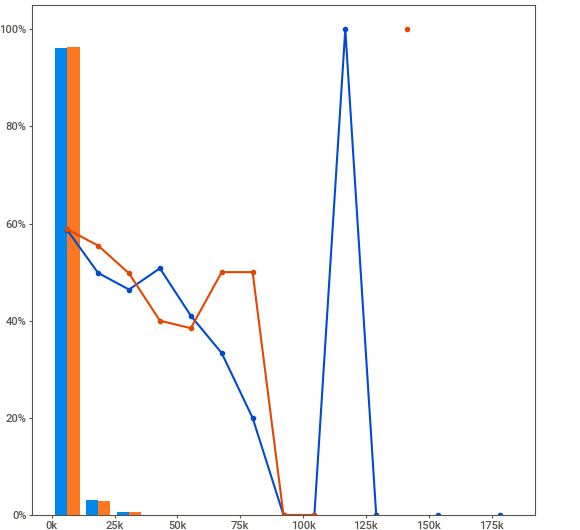
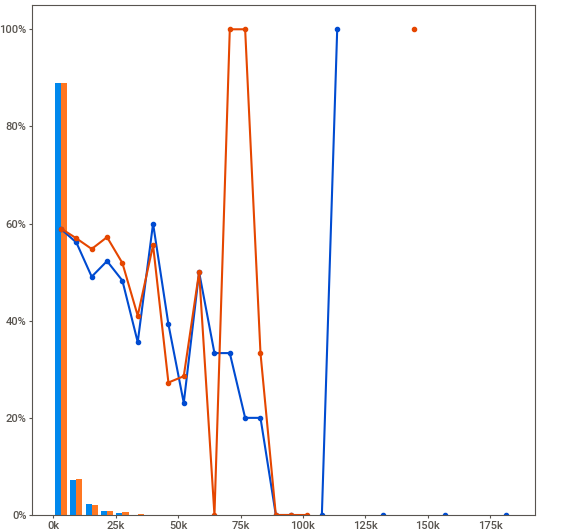
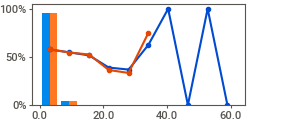
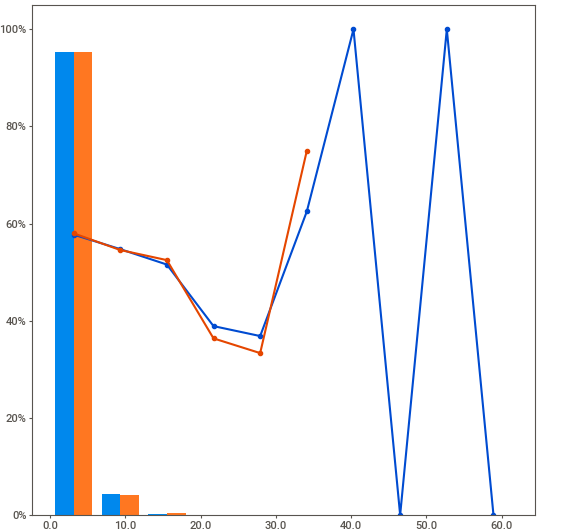
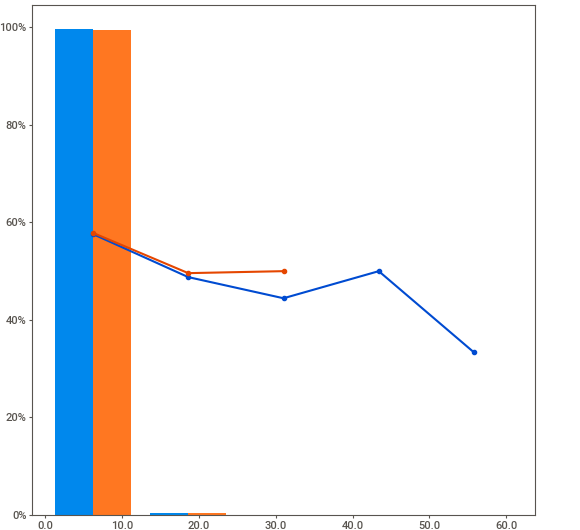
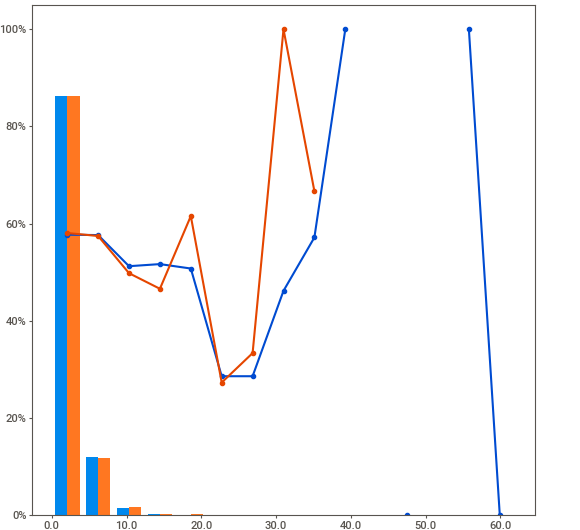
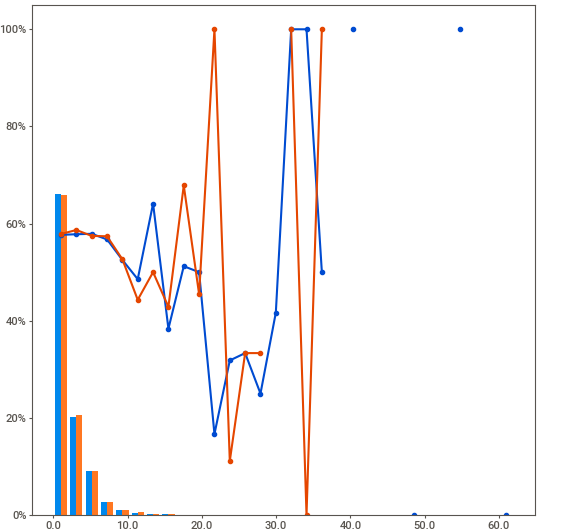
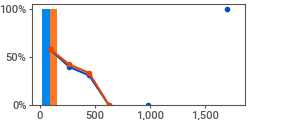
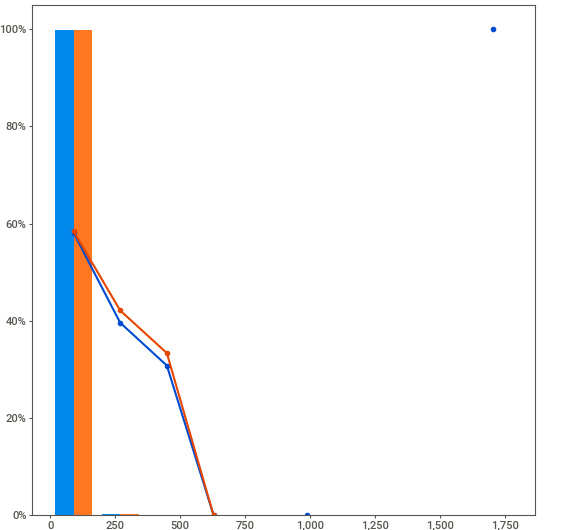
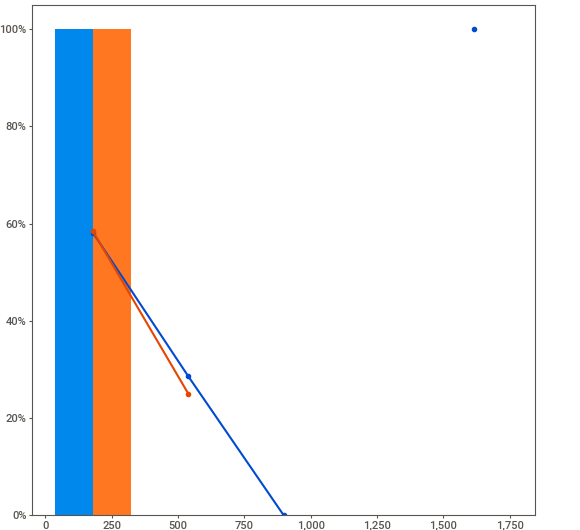
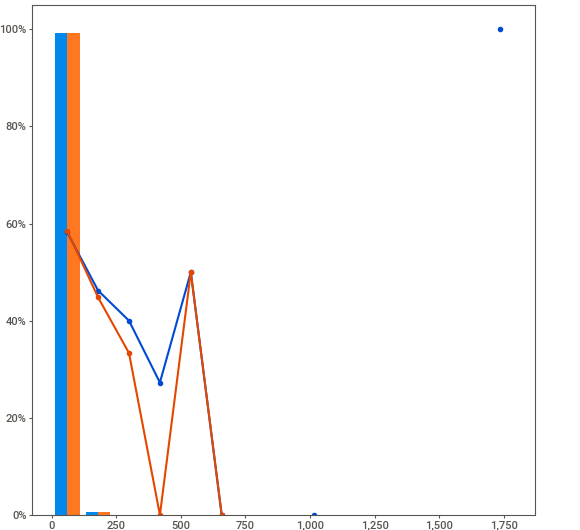
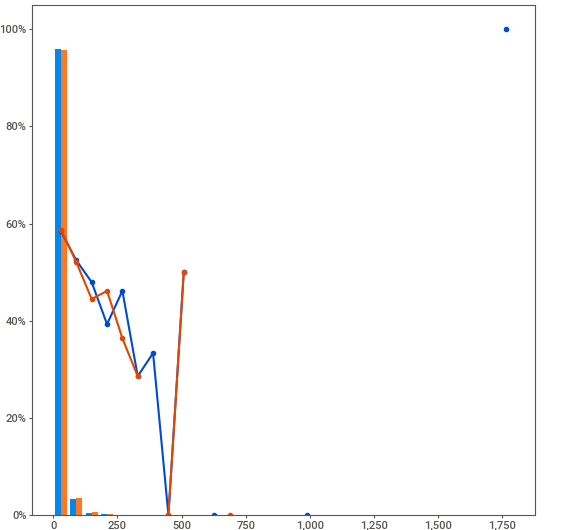
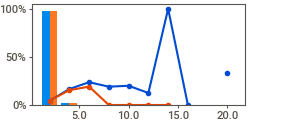
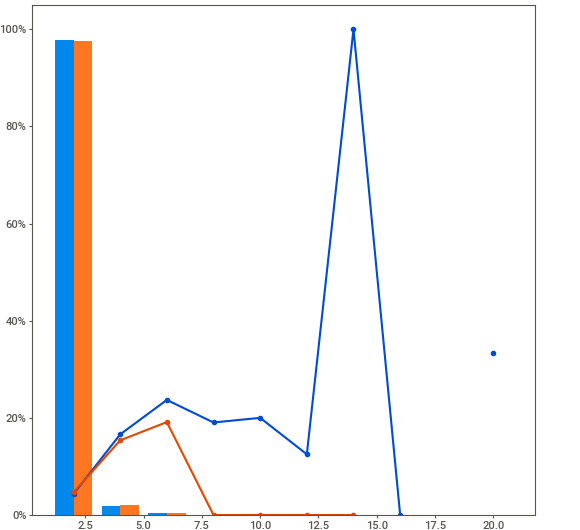
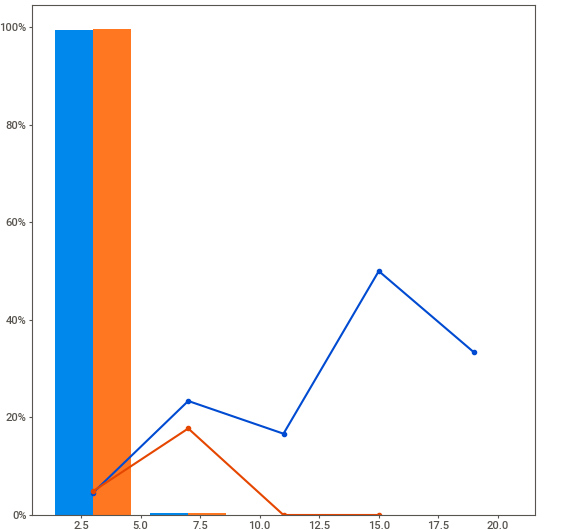
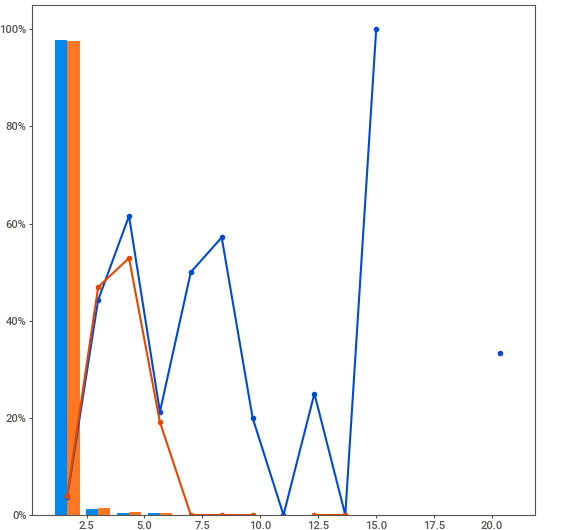
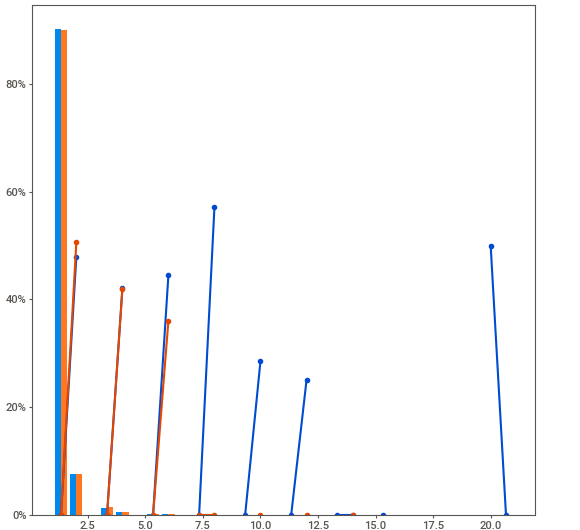
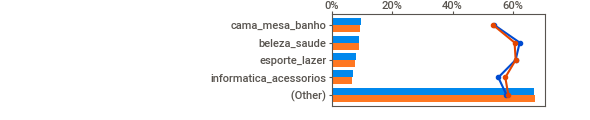
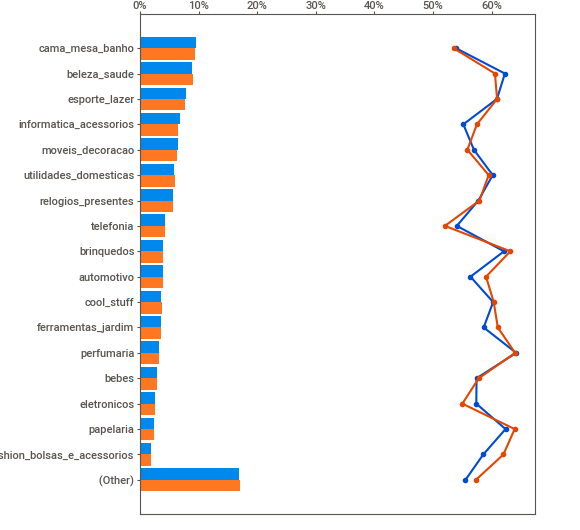
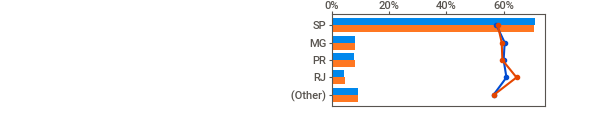
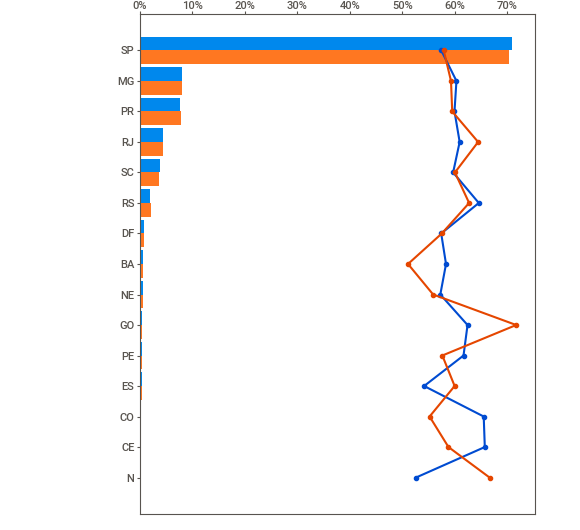
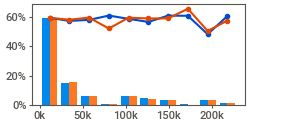
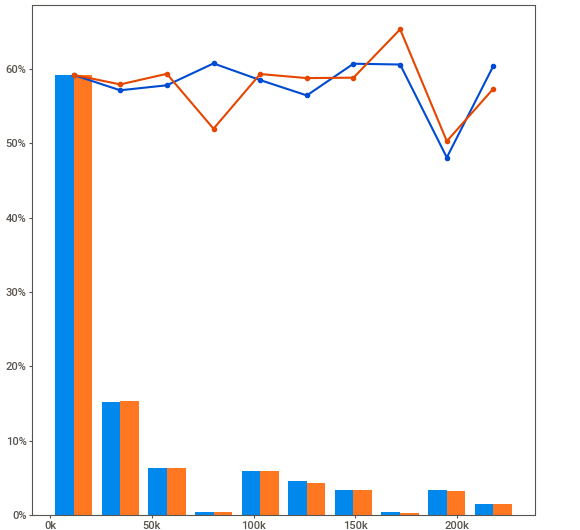
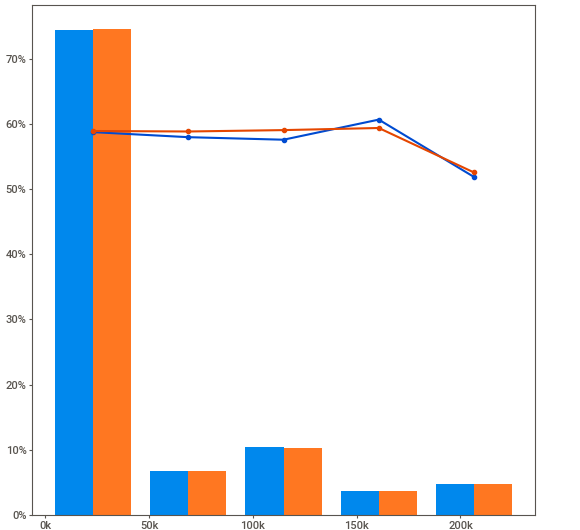
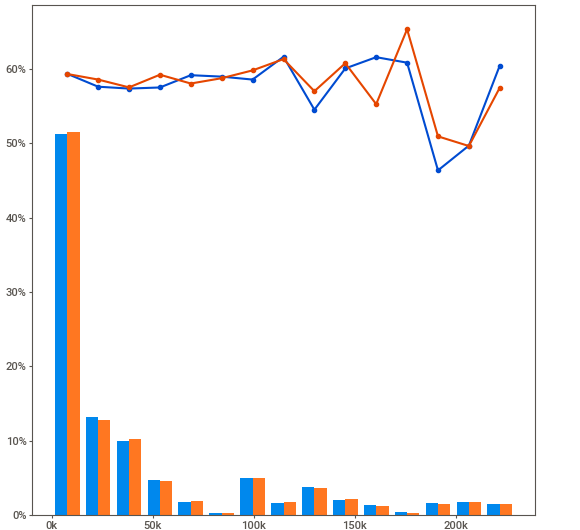
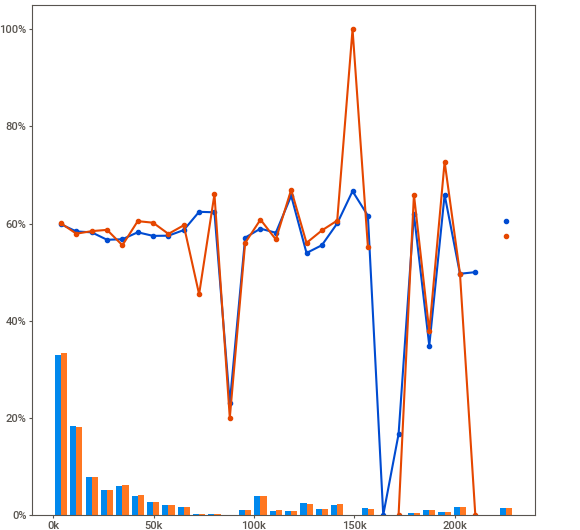
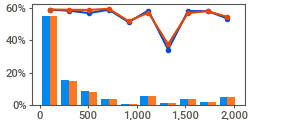
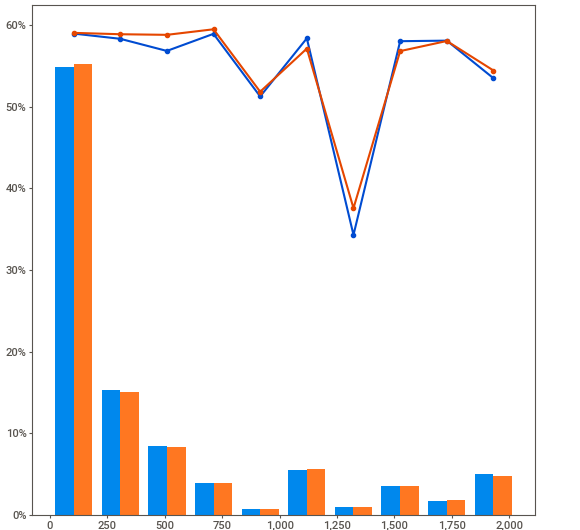
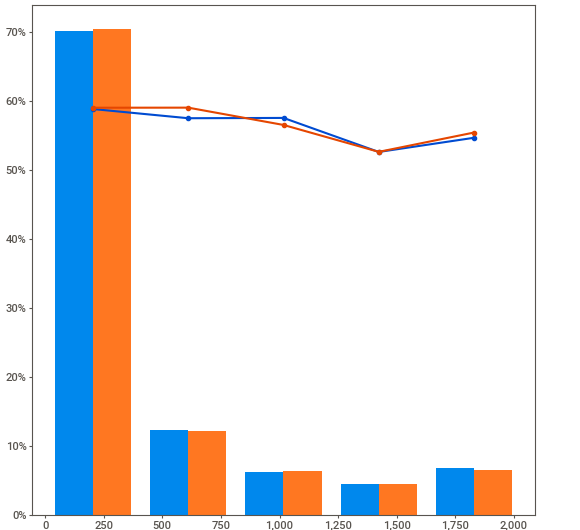
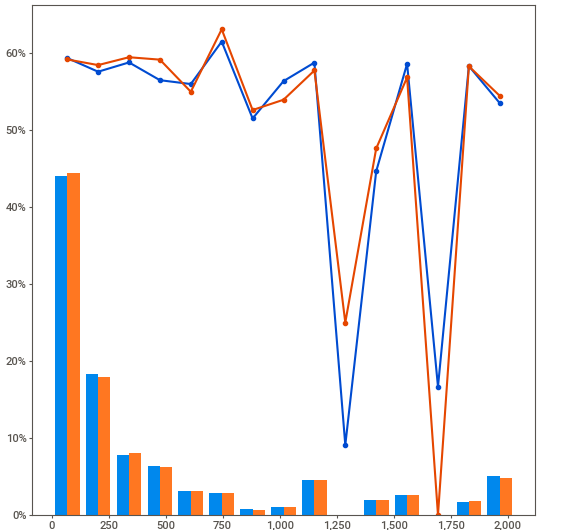
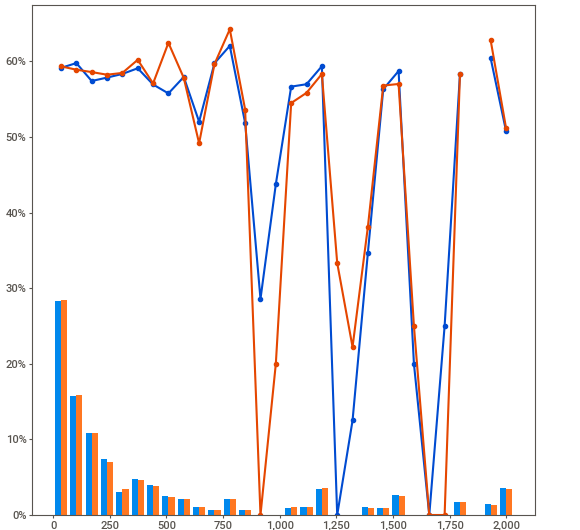
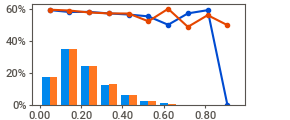
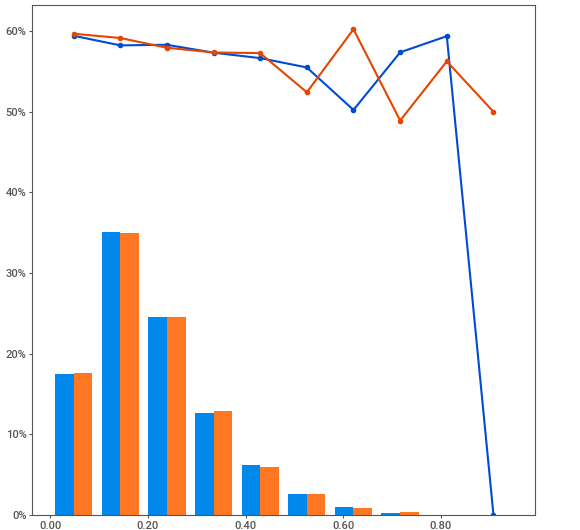
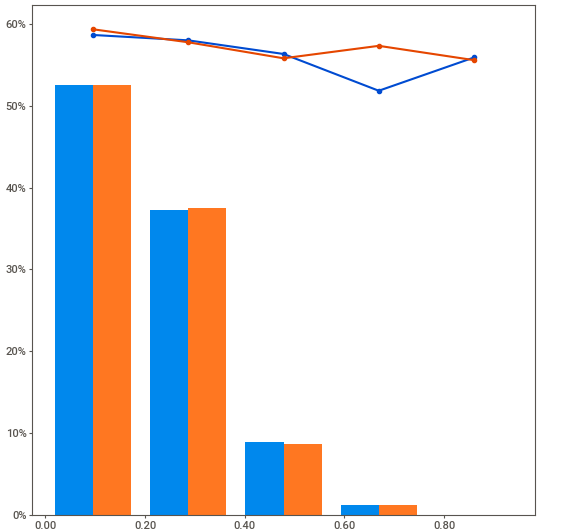
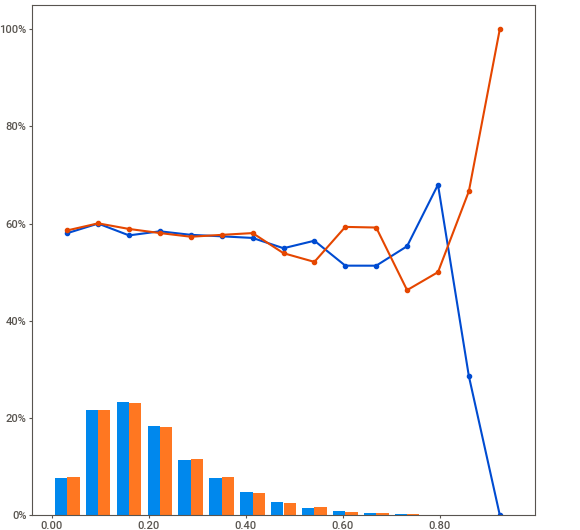
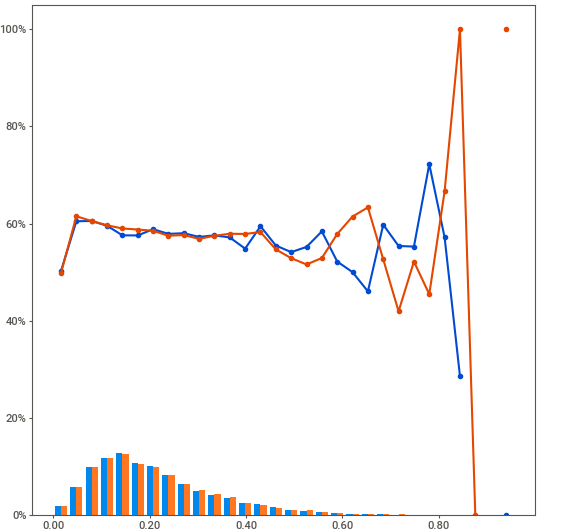
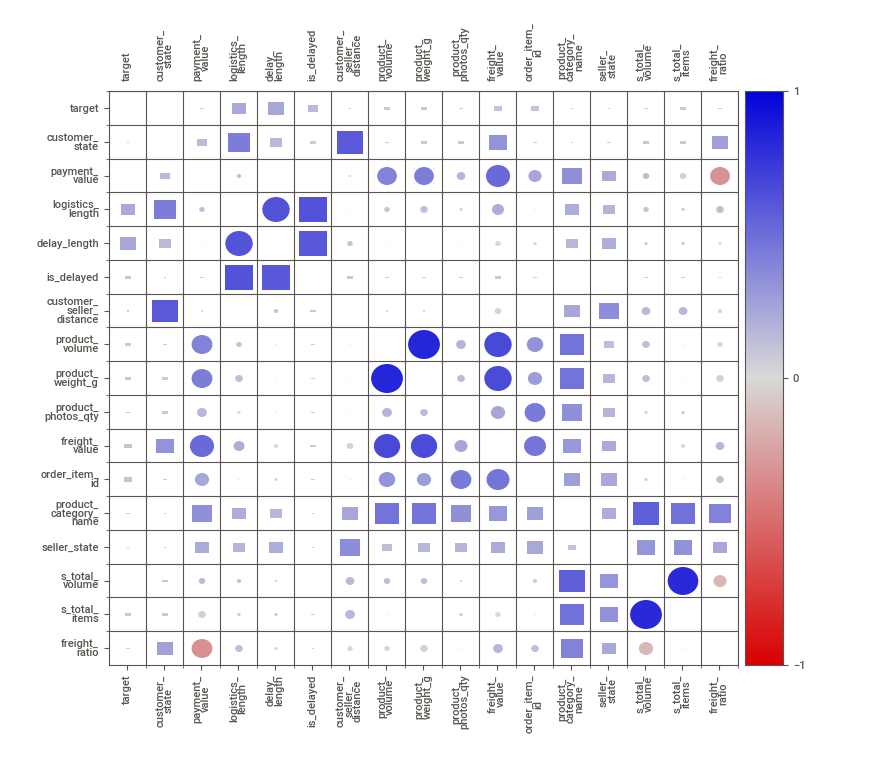
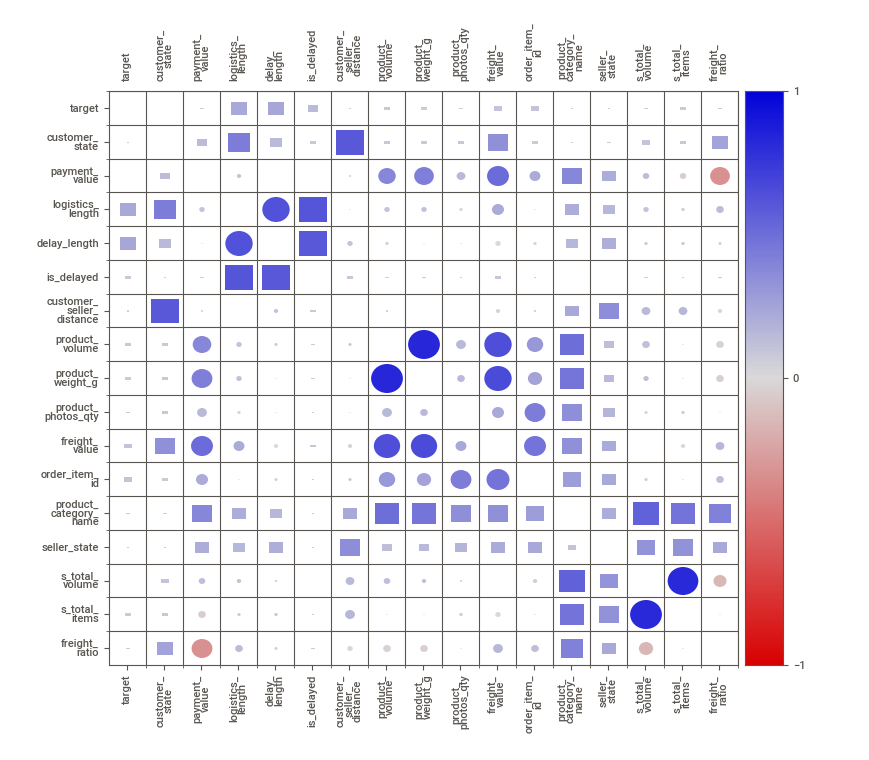

In [ ]:
comparison_report.show_notebook()

In [ ]:
!pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
import fs

In [ ]:
features = [x for x in df.columns if x != 'target']
target = 'target'
categorical_features = ['customer_state', 'product_category_name', 'seller_state', 'is_delayed']

In [ ]:
fselection = fs.FeatureSelector(df[features], labels = df[target])

In [ ]:
fselection.identify_all({
     'missing_threshold' : 0.8,
     'correlation_threshold' : 0.95,
     'eval_metric' : 'accuracy',
     'task' : 'classification',
     'cumulative_importance' : 0.8,
     'categorical_features' : categorical_features,
     'categorical_method' : "CE"
})

0 features with greater than 0.80 missing values.

0 features with a single unique value.

0 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.620693
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.624814
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.624256
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.626398
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.621805
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	valid_0's binary_

In [ ]:
fselection.feature_importances

feature  importance  normalized_importance  \
0               delay_length       511.5               0.118815   
1           logistics_length       417.4               0.096957   
2      product_category_name       377.5               0.087689   
3              s_total_items       351.1               0.081556   
4             product_volume       329.3               0.076492   
5              freight_value       325.6               0.075633   
6              payment_value       318.9               0.074077   
7              freight_ratio       313.5               0.072822   
8           product_weight_g       313.0               0.072706   
9             s_total_volume       287.7               0.066829   
10  customer_seller_distance       261.8               0.060813   
11            customer_state       177.6               0.041254   
12             order_item_id       114.9               0.026690   
13        product_photos_qty       110.0               0.025552   
14              seller_state        95.1               0.022091   
15                is_delayed         0.1               0.000023   

    cumulative_importance  
0                0.118815  
1                0.215772  
2                0.303461  
3                0.385017  
4                0.461510  
5                0.537143  
6                0.611220  
7                0.684042  
8                0.756748  
9                0.823577  
10               0.884390  
11               0.925645  
12               0.952334  
13               0.977886  
14               0.999977  
15               1.000000

Vemos que as features tem baixa correlação com o target, porém significa apenas que não existem relações lineares fortes. Vamos testá-las a frente com um modelo mais robusto. Como temos poucas variáveis, resolvi não eliminar nenhuma (decisão que pode ser revista)

## Baseline Model

Dividindo dataset entre treino, teste e validação e testando um modelo xgboost

In [ ]:
from sklearn.model_selection import KFold
import category_encoders as ce
import xgboost
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
df.dropna(inplace = True)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df[features], df[target], test_size = 0.15)
Original_X_test = X_test.copy(deep = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.20)

Testando um novo tipo de encoder de variáveis categóricas, o CatBoostEncoder, que tem se mostrado bem utilizado na prática. Porém, é importante se atentar ao overfitting. Em um projeto real, diferentes tipos de encoding deveriam ser testados.

Dessa forma, vamos fazer nossos testes usando conjuntos de treino, validação e teste. No conjunto treino + validação, vamos executar a validação cruzada.

É importante não contaminar os dados de validação nas diferentes execuções da validação cruzada com dados de treino (data leakage). Logo, abaixo vamos salvar os dados de treino/validação para cada iteração "aprendendo" as trasformações nos conjuntos de treino e somente aplicando nos conjuntos de validação.

In [ ]:
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = True, random_state = 42)

CV_Data = []

for id_train, id_val in kf.split(X_train_val):
  X_train = X_train_val.iloc[id_train, :]
  y_train = y_train_val.iloc[id_train]
  X_val   = X_train_val.iloc[id_val, :]
  y_val   = y_train_val.iloc[id_val]

  encoder = ce.CatBoostEncoder(cols = categorical_features)

  encoder.fit(X_train, y_train)
  X_train = encoder.transform(X_train)
  X_val = encoder.transform(X_val)

  CV_Data.append((X_train, y_train, X_val, y_val))


In [ ]:
def cross_validation(model):
  metrics = []
  for X_train, y_train, X_val, y_val in CV_Data:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    metrics.append(acc)
  return metrics

In [ ]:
encoder = ce.CatBoostEncoder(cols = categorical_features)
encoder.fit(X_train_val, y_train_val)
X_train_val = encoder.transform(X_train_val)
X_test = encoder.transform(X_test)

Exemplo dos dados processados e com somente variáveis numéricas.

In [ ]:
X_train_val.head()

customer_state  payment_value  logistics_length  delay_length  \
16423        0.575742          87.64              34.0           6.0   
14282        0.575742          51.04              13.0         -15.0   
1103         0.621982        1291.39               9.0           2.0   
11335        0.599420        1122.45               9.0         -11.0   
6597         0.621982         213.06              21.0          -1.0   

       is_delayed  customer_seller_distance  product_volume  product_weight_g  \
16423    0.176110                941.579049         23625.0             950.0   
14282    0.625193               1142.183838          4500.0             200.0   
1103     0.176110                 11.352387         54080.0           11450.0   
11335    0.625193                328.984396         15625.0             900.0   
6597     0.625193                 36.082289         62620.0           20900.0   

       product_photos_qty  freight_value  order_item_id  \
16423                 1.0          17.74            1.0   
14282                 1.0          16.05            1.0   
1103                  1.0          51.39            1.0   
11335                 2.0          22.46            1.0   
6597                  2.0          43.07            1.0   

       product_category_name  seller_state  s_total_volume  s_total_items  \
16423               0.548348       0.58569       200472.92         1987.0   
14282               0.631675       0.58569       104288.42         1775.0   
1103                0.631675       0.58569        15633.40           33.0   
11335               0.570712       0.58569         9619.09           34.0   
6597                0.424684       0.58569        10022.82           78.0   

       freight_ratio  
16423       0.202419  
14282       0.314459  
1103        0.039794  
11335       0.020010  
6597        0.202150

O hiperparâmetro` tree_method = "gpu_hist"` significa que vamos treinar utilizando GPU. Caso você não tenha uma GPU, é só remover este hiperparâmetro

In [ ]:
model = xgboost.XGBClassifier(n_estimators = 100, tree_method = 'gpu_hist')
cv_score = cross_validation(model)

In [ ]:
print("{:.2%} +- {:.2%}".format(np.mean(cv_score), np.std(cv_score, ddof=1)))

61.06% +- 1.30%


## Hyperparameter Tuning

Vamos utilizar o optuna para otimizar os hiperparâmetros, pois o espaço de busca do Xgboost pode se tornar grande.

No optuna, basicamente, deve-se definir apenas um espaço de busca, ou seja, quais parâmetros e seus domínios vamos otimizar e uma função que retorna a métrica a ser maximizado ou minimizada.

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
def objective(trial):
  param_grid = {
        'seed' : 42,
        #'tree_method':'gpu_hist',
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256, step = 10),
        "max_depth": trial.suggest_categorical("max_depth", [0, 1, 5, 10, 20, 50]),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200, 500, 1000]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

  metrics = []

  model = xgboost.XGBClassifier(**param_grid)
  cv_score = cross_validation(model)

  return np.mean(cv_score)

study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout = 120 * 60, n_trials=5000, n_jobs = -1)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))


[I 2024-06-19 19:34:43,870] A new study created in memory with name: no-name-8e9ccf71-f109-4d35-9883-77598d7664f3
[I 2024-06-19 19:34:46,333] Trial 0 finished with value: 0.6436035359226706 and parameters: {'learning_rate': 0.2866030938129226, 'num_leaves': 112, 'max_depth': 1, 'lambda_l1': 5.873415090297445e-08, 'lambda_l2': 2.1725840192141725e-08, 'min_gain_to_split': 2.126405131676602, 'n_estimators': 200, 'feature_fraction': 0.9959377792524149, 'bagging_fraction': 0.7365423132274912, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 0 with value: 0.6436035359226706.
[I 2024-06-19 19:34:47,410] Trial 1 finished with value: 0.6281403456052045 and parameters: {'learning_rate': 0.22763297150813291, 'num_leaves': 172, 'max_depth': 5, 'lambda_l1': 0.0003130588627631028, 'lambda_l2': 0.0002092326102125147, 'min_gain_to_split': 1.5512656554959536, 'n_estimators': 100, 'feature_fraction': 0.5215148151841094, 'bagging_fraction': 0.8016996997871306, 'bagging_freq': 5, 'min_child_samp

Best trial:
  Value: 0.6474511912716958
  Params: 
    learning_rate: 0.20708037652300287
    num_leaves: 212
    max_depth: 1
    lambda_l1: 0.279236394729972
    lambda_l2: 0.001241581343466602
    min_gain_to_split: 4.522030707238138
    n_estimators: 50
    feature_fraction: 0.8199144471427575
    bagging_fraction: 0.6888236601204009
    bagging_freq: 2
    min_child_samples: 55


In [ ]:
with open("/gdrive/MyDrive/Yandex/labs/e2eopt.pkl", 'wb') as f:
  pickle.dump(trial.params, f)

In [ ]:
with open("/gdrive/MyDrive/Yandex/labs/study.pkl", 'wb') as f:
  pickle.dump(study, f)

A ferramenta o optuna nos permite fazer check de como os hiperparâmetros se comportaram durante a otimização Verifique alguns exemplos [aqui](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html)

Vamos salvar os melhores hiperparâmetros obtidos.

In [ ]:
best_params = {'learning_rate': 0.20708037652300287,
 'num_leaves': 212,
 'max_depth': 1,
 'lambda_l1': 0.279236394729972,
 'lambda_l2': 0.001241581343466602,
 'min_gain_to_split': 4.522030707238138,
 'n_estimators': 50,
 'feature_fraction': 0.8199144471427575,
 'bagging_fraction': 0.6888236601204009,
 'bagging_freq': 2,
 'min_child_samples': 55}

Vamos analisar o resultado da validação cruzada para o modelo xgboost final:

In [ ]:
model = xgboost.XGBClassifier(**best_params)
cv_score = cross_validation(model)

In [ ]:
print("{:.2%} +- {:.2%}".format(np.mean(cv_score), np.std(cv_score, ddof=1)))

64.77% +- 0.52%


## Model Analysis

Avaliando o modelo e os erros. Neste ponto, é necessário aprofundar a análise para entender quais variáveis adicionais podemos criar.

Também é necessário aprofundar nas métricas a serem avaliadas.

O modelo resultante tem performance não satisfatória.


In [ ]:
model = xgboost.XGBClassifier(**best_params)
model.fit(X_train_val, y_train_val)

y_pred_test = model.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
print(f"Acurácia final: {acc:.2%}")

Acurácia final: 63.60%


#### Feature importance do modelo

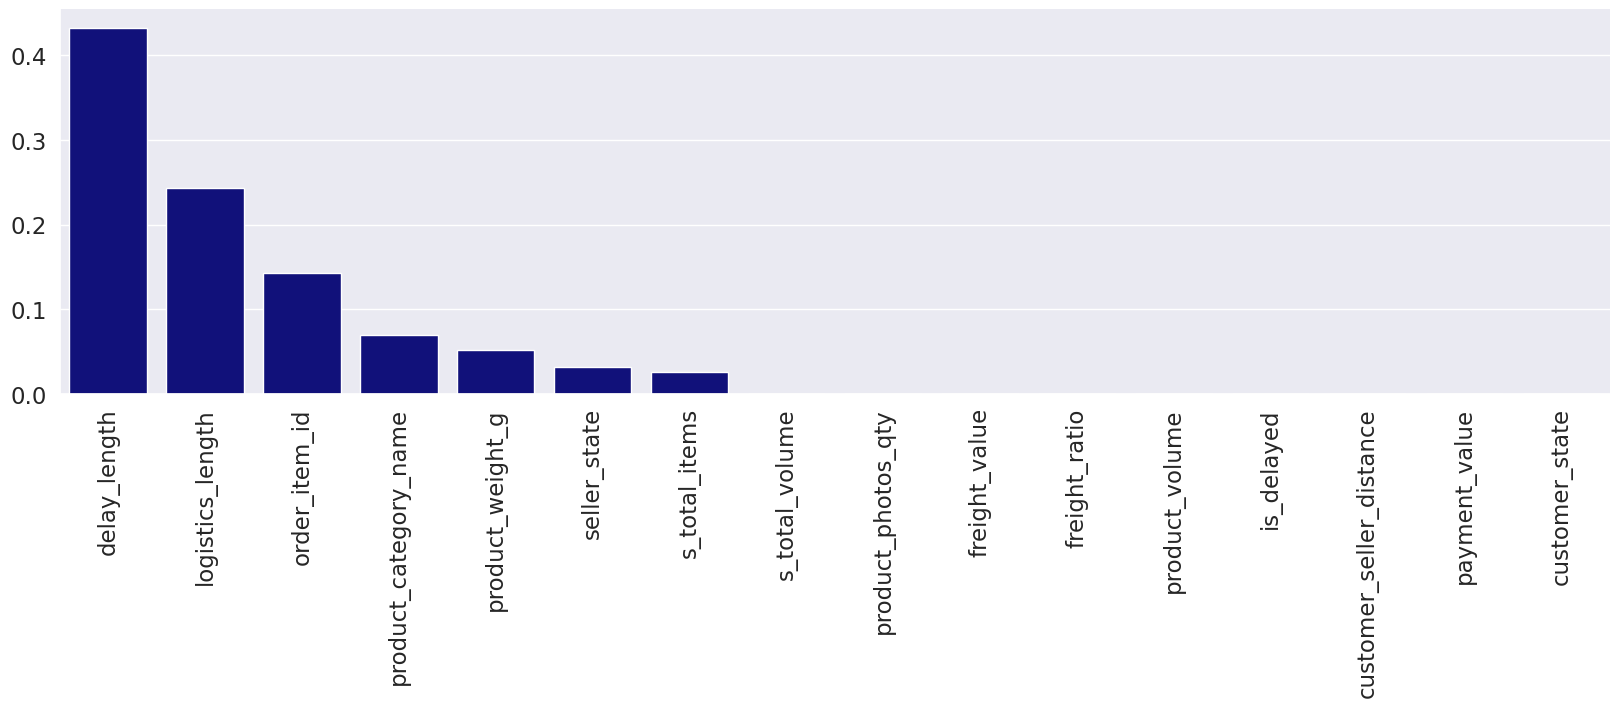

In [ ]:
indexes = np.argsort(model.feature_importances_)[::-1]
coef = model.feature_importances_[indexes]

fig, ax = plt.subplots(figsize = (20,5))
sns.barplot(x = np.array(features)[indexes], y = coef, ax = ax, color = 'darkblue')
plt.xticks(rotation = 90)
sns.despine()

### Analisando a distribuição da performance do modelo com bootstrapping

In [ ]:
accs = []

for i in range(300):
  model = xgboost.XGBClassifier(**best_params)
  x_sample = X_train_val.sample(n = len(X_train_val), replace = True)
  y_sample = y_train_val[x_sample.index]
  model.fit(x_sample, y_sample)

  y_pred_test = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred_test)
  accs.append(acc)

Acurácia média de 63.43% com CI 95% [62.85%,63.99%]


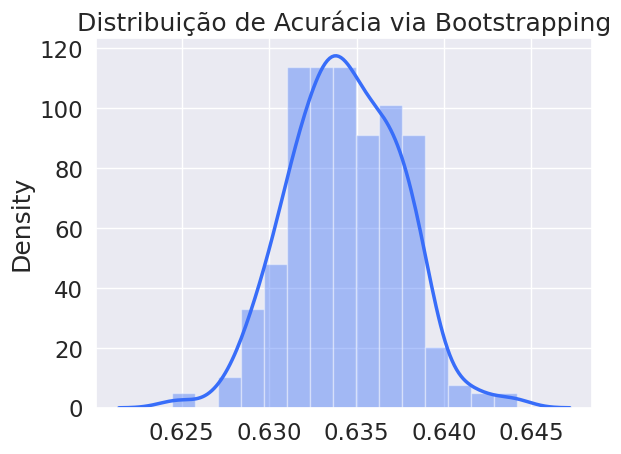

In [ ]:
sns.distplot(x = accs);
plt.title("Distribuição de Acurácia via Bootstrapping")
print(f"Acurácia média de {np.mean(accs):.2%} com CI 95% [{np.percentile(accs, 2.5):.2%},{np.percentile(accs, 97.5):.2%}]")

### Explicabilidade

In [ ]:
!pip install shap --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.4 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

Um overview das variáveis mais importantes e para qual direção está levando as predições

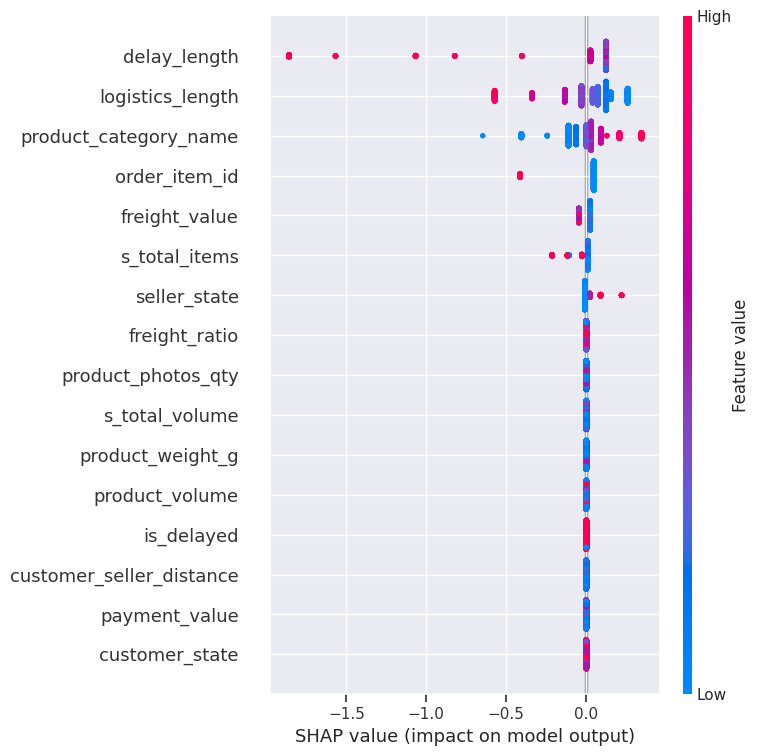

In [ ]:
shap.summary_plot(shap_values, X_test)

Um exmeplo para uma amostra única

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[[0]])

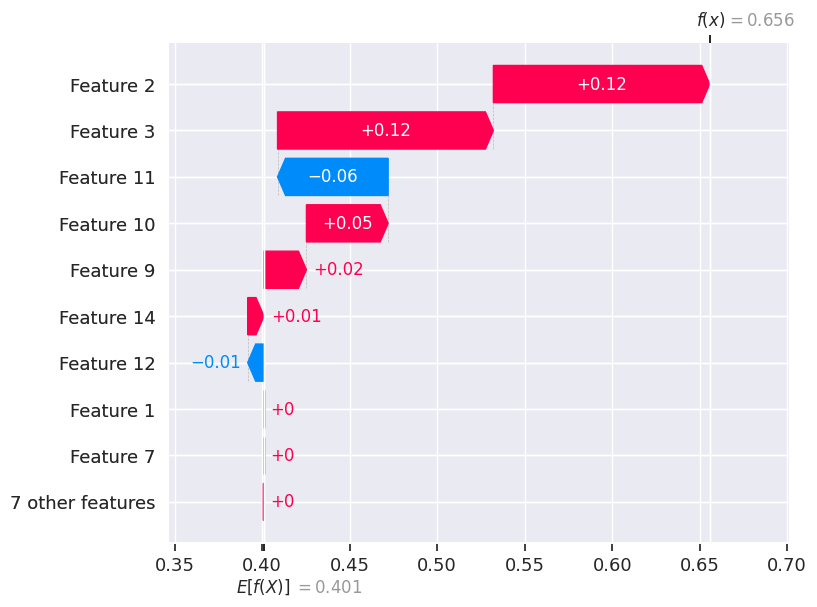

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0])

### Thresholds

Vamos supor que neste exemplo, queremos dar um cupom de desconto de R\$ 20.00 para os clientes que classificarem como ruim a entrega. Se o cliente receber o desconto, ele não sofre churn. Cada cliente tem um LTV de R\$ 50,00

A função `confusion_matrix` do sklearn retorna

- [0,0]: verdadeiro negativo
- [1,0]: falso negativo
- [0,1]: falso positivo e
- [1,1]: verdadeiro positivo

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
y_prob = model.predict_proba(X_test)[:,1]

In [ ]:
risk = []
thresholds = np.linspace(0,1,21)

for p in thresholds:
  cm = confusion_matrix(y_test, (y_prob > p))
  risk.append(cm[0,0] * (-20 + 50) + cm[1,1] * 50 + cm[0,1] * (0) + cm[1,0] * (-20 + 50))

O threshold = 0.6 maximiza o nosso retorno financeiro. Então, deveríamos utilizar o threshold de 0.6 para classificar um cliente como potencialmente alguém que faria uma avaliação 5 estrelas.

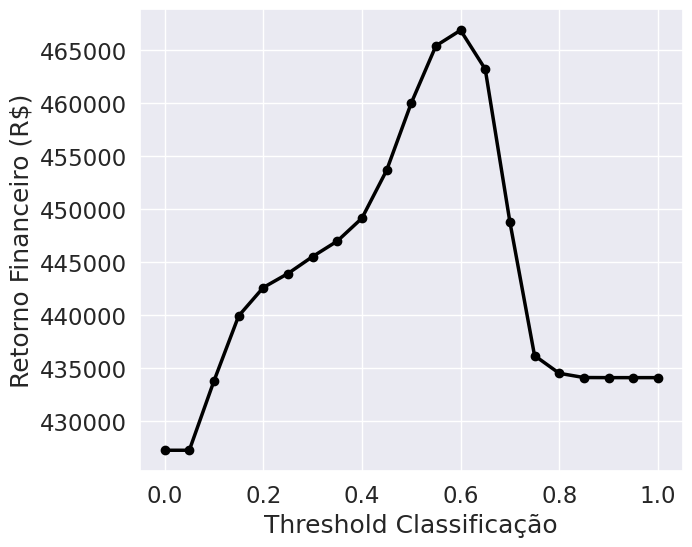

In [ ]:
fig, ax = plt.subplots(figsize = (7,6))
plt.plot(thresholds, risk, 'o-k');
plt.ylabel("Retorno Financeiro (R$)")
plt.xlabel("Threshold Classificação");

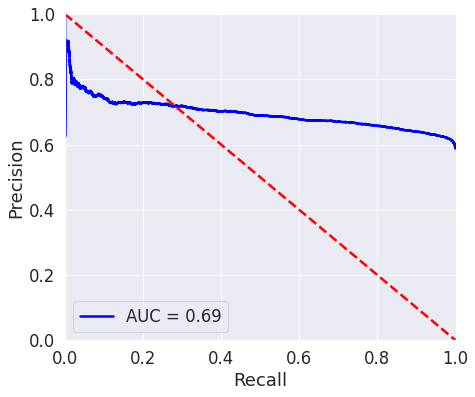

In [ ]:
precision, recall, ts_pr  = metrics.precision_recall_curve(y_test, y_prob)
roc_auc = metrics.auc(recall, precision)

fig, ax = plt.subplots(figsize = (7,6))
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower left')
plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
sns.despine()

### Error Analysis

Aprofundando na análise do erro, podemos ver quais subgrupos tiveram maior erro e tentar ter ideias de como podemos melhorar nosso modelo

In [ ]:
Original_X_test['Error'] = y_test != (y_prob > 0.6) # utilizando threhsold calculado no passo anterior

In [ ]:
Original_X_test.head()

customer_state  payment_value  logistics_length  delay_length  \
48058             BA         306.76              19.0         -20.0   
8843              SP          48.79              11.0          -2.0   
92296             SP          69.72               7.0         -14.0   
21093             SP         135.08              11.0         -11.0   
45773             SP          62.81               6.0         -15.0   

       is_delayed  customer_seller_distance  product_volume  product_weight_g  \
48058       False               1205.120788         13200.0            3300.0   
8843        False                 20.248986          8000.0             800.0   
92296       False                356.973138          7224.0            1800.0   
21093       False                315.161402          8000.0            6050.0   
45773       False                197.947101          3872.0             250.0   

       product_photos_qty  freight_value  order_item_id  \
48058                10.0          36.76            2.0   
8843                  5.0           9.34            1.0   
92296                 2.0          21.82            1.0   
21093                 1.0          45.09            1.0   
45773                 3.0          13.01            1.0   

             product_category_name seller_state  s_total_volume  \
48058  fashion_bolsas_e_acessorios           MG         5324.15   
8843               cama_mesa_banho           SP         9553.62   
92296             moveis_decoracao           PR         4829.24   
21093           ferramentas_jardim           MG       101901.16   
45773              cama_mesa_banho           SP         1400.00   

       s_total_items  freight_ratio  Error  
48058           41.0       0.119833   True  
8843           220.0       0.191433  False  
92296           45.0       0.312966  False  
21093          770.0       0.333802  False  
45773           32.0       0.207133  False

In [ ]:
Original_X_test.groupby('seller_state').agg({'Error' : ['mean', 'count']}).sort_values(by = ('Error', 'mean'))

Error       
                  mean  count
seller_state                 
N             0.000000      1
CE            0.250000      8
BA            0.293333     75
CO            0.344828     29
RJ            0.358462    650
PR            0.363148   1118
SC            0.365503    487
MG            0.375993   1133
SP            0.378083  10339
PE            0.381579     76
GO            0.381818     55
RS            0.384615    260
DF            0.386555    119
NE            0.402439     82
ES            0.578947     38

In [ ]:
Original_X_test.groupby('customer_state').agg({'Error' : ['mean', 'count']}).sort_values(by = ('Error', 'mean'))

Error      
                    mean count
customer_state                
RJ              0.357843  1836
SP              0.369170  6046
CO              0.369565   276
SC              0.370093   535
MG              0.377930  1749
PE              0.378601   243
PR              0.379066   707
NE              0.383562   438
RS              0.388594   754
BA              0.389105   514
DF              0.399317   293
ES              0.408537   328
CE              0.410256   195
N               0.412214   262
GO              0.431973   294

In [ ]:
Original_X_test.groupby('product_category_name').agg({'Error' : ['mean', 'count']}).sort_values(by = ('Error', 'count'), ascending = False)

Error      
                                                   mean count
product_category_name                                        
cama_mesa_banho                                0.430882  1360
beleza_saude                                   0.354864  1254
esporte_lazer                                  0.330882  1088
moveis_decoracao                               0.396694   968
informatica_acessorios                         0.424658   949
...                                                 ...   ...
artes_e_artesanato                             0.666667     3
fashion_roupa_infanto_juvenil                  0.000000     2
portateis_cozinha_e_preparadores_de_alimentos  0.500000     2
la_cuisine                                     0.000000     1
seguros_e_servicos                             1.000000     1

[73 rows x 2 columns]

### Outros Pacotes (TO DO)

In [ ]:
!pip install --upgrade interpret-community
!pip install --upgrade raiwidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# from interpret.ext.blackbox import TabularExplainer

In [ ]:
from raiwidgets import ErrorAnalysisDashboard
ErrorAnalysisDashboard(dataset=X_test, true_y=y_test, features=features, pred_y=y_pred_test)

In [ ]:
# 1. Using SHAP TabularExplainer
explainer = TabularExplainer(model,
                             X_train_val,
                             features=features,
                             classes=[0, 1])

In [ ]:
global_explanation = explainer.explain_global(X_test)

In [ ]:
# Sorted SHAP values
print('ranked global importance values: {}'.format(global_explanation.get_ranked_global_values()))
# Corresponding feature names
print('ranked global importance names: {}'.format(global_explanation.get_ranked_global_names()))
# Feature ranks (based on original order of features)
print('global importance rank: {}'.format(global_explanation.global_importance_rank))

# Note: Do not run this cell if using PFIExplainer, it does not support per class explanations
# Per class feature names
print('ranked per class feature names: {}'.format(global_explanation.get_ranked_per_class_names()))
# Per class feature importance values
print('ranked per class feature values: {}'.format(global_explanation.get_ranked_per_class_values()))

ranked global importance values: [0.2968268243474074, 0.21114847418217286, 0.08548077051792205, 0.08272935384422983, 0.02469835728241496, 0.01832819414391645, 0.014156197334203535, 0.013201658878334813, 0.012948776185635674, 0.01276526830820255, 0.012435662924018414, 0.009784487073498545, 0.009744327515109508, 0.007975796738444015, 0.0056768230096239285, 0.0]
ranked global importance names: ['delay_length', 'logistics_length', 'order_item_id', 'product_category_name', 's_total_items', 'customer_state', 's_total_volume', 'freight_value', 'seller_state', 'product_weight_g', 'product_volume', 'freight_ratio', 'payment_value', 'customer_seller_distance', 'product_photos_qty', 'is_delayed']
global importance rank: [3, 2, 10, 11, 14, 0, 13, 9, 12, 7, 6, 15, 1, 5, 8, 4]
ranked per class feature names: [['delay_length', 'logistics_length', 'order_item_id', 'product_category_name', 's_total_items', 'customer_state', 's_total_volume', 'freight_value', 'seller_state', 'product_weight_g', 'product

In [ ]:
print('global importance rank: {}'.format(global_explanation.get_feature_importance_dict()))


global importance rank: {'delay_length': 0.2968268243474074, 'logistics_length': 0.21114847418217286, 'order_item_id': 0.08548077051792205, 'product_category_name': 0.08272935384422983, 's_total_items': 0.02469835728241496, 'customer_state': 0.01832819414391645, 's_total_volume': 0.014156197334203535, 'freight_value': 0.013201658878334813, 'seller_state': 0.012948776185635674, 'product_weight_g': 0.01276526830820255, 'product_volume': 0.012435662924018414, 'freight_ratio': 0.009784487073498545, 'payment_value': 0.009744327515109508, 'customer_seller_distance': 0.007975796738444015, 'product_photos_qty': 0.0056768230096239285, 'is_delayed': 0.0}


In [ ]:
instance_num = 1
local_explanation = explainer.explain_local(X_test[:instance_num])

In [ ]:
prediction_value = model.predict(X_test)[instance_num]

sorted_local_importance_values = local_explanation.get_ranked_local_values()[prediction_value]
sorted_local_importance_names = local_explanation.get_ranked_local_names()[prediction_value]

print('local importance values: {}'.format(sorted_local_importance_values))
print('local importance names: {}'.format(sorted_local_importance_names))

local importance values: [[0.21527042984962463, 0.08310376852750778, 0.056644171476364136, 0.013607196509838104, 0.007066185120493174, 0.0, -0.002399129094555974, -0.004056863021105528, -0.004547412507236004, -0.007153434678912163, -0.007591162342578173, -0.009179267100989819, -0.010742017067968845, -0.012527929618954659, -0.018542246893048286, -0.020794769749045372]]
local importance names: [['delay_length', 'logistics_length', 'order_item_id', 'product_weight_g', 'freight_value', 'is_delayed', 's_total_volume', 'freight_ratio', 'customer_seller_distance', 'product_volume', 'seller_state', 'payment_value', 's_total_items', 'customer_state', 'product_category_name', 'product_photos_qty']]


In [ ]:
ErrorAnalysisDashboard(global_explanation, model, dataset=X_test, true_y=y_test)


### TO DO Model Analysis (evidently)
https://www.evidentlyai.com/

In [ ]:
!pip install git+https://github.com/evidentlyai/evidently.git

  Cloning https://github.com/evidentlyai/evidently.git to /tmp/pip-req-build-f0kb_p24
  Running command git clone --filter=blob:none --quiet https://github.com/evidentlyai/evidently.git /tmp/pip-req-build-f0kb_p24
  Resolved https://github.com/evidentlyai/evidently.git to commit bf80fefd291173cb6568908e247f015984796d07
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.8 MB/s eta 0:00:00
  Created wheel for evidently: filename=evidently-0.4.9-py3-none-any.whl size=3303633 sha256=ba3411a8627235ff67da858ad96c796df57abb384b6ff867f974e01163bed366
  Stored in directory: /tmp/pip-ephem-wheel-cache-ovzebz8x/wheels/b9/63/7b/170638c7d0b5772f1e76c1d9adefc91eee2697a23b337135e0
Successfully built evidently
  At